In [334]:
import bs4
from bs4 import BeautifulSoup
import requests
import re
import json
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_palette('muted')
sns.set_style('whitegrid')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, \
ExtraTreesRegressor, GradientBoostingRegressor,\
AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, \
RandomForestClassifier, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

## Webscraping

### IMDB: Get film ids

In [3]:
# Function that will make an api call to omdbapi.com and return film id

def get_id_250():
    response = requests.get('http://www.imdb.com/chart/top')
    html = response.text
    entries = re.findall("<a href.*?/title/(.*?)/", html)
    return list(set(entries))

entries = get_id_250()

In [4]:
print len(entries)
print entries[:2]

250
[u'tt2582802', u'tt0047478']


### Fill in film data from omdapi.com

In [5]:
# Function that will make an api call to omdbapi.com and return film data by film id

#Decided to include Rotten Tomatoes ratings and metrics as it may also be a useful feature in models 

# From JSON/APIs lab
def get_entry(entry):
    res = requests.get('http://www.omdbapi.com/?i='+entry+'&plot=full&r=json&tomatoes=true')
    if res.status_code != 200:
        print entry, res.status_code
    else:
        print '.',
    try:
        j = json.loads(res.text)
    except ValueError:
        j = None
    return j

entries_dict_list = [get_entry(e) for e in entries]

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


In [6]:
len(entries_dict_list)

250

In [7]:
df = pd.DataFrame(entries_dict_list)
df.head(1)

,Actors,Awards,BoxOffice,Country,DVD,Director,Genre,Language,Metascore,Plot,...,tomatoFresh,tomatoImage,tomatoMeter,tomatoRating,tomatoReviews,tomatoRotten,tomatoURL,tomatoUserMeter,tomatoUserRating,tomatoUserReviews
0,"Miles Teller, J.K. Simmons, Paul Reiser, Melis...",Won 3 Oscars. Another 87 wins & 131 nominations.,N/A,USA,24 Feb 2015,Damien Chazelle,"Drama, Music",English,88,A promising young drummer enrolls at a cut-thr...,...,246,certified,94,8.6,261,15,http://www.rottentomatoes.com/m/whiplash_2014/,94,4.5,66092


In [8]:
print df.shape

(250, 35)


### IMDB: Get gross, opening weekend and budget

In [9]:
def get_gross(entry):
    response = requests.get('http://www.imdb.com/title/' + entry)
    html = response.text
    try:
        gross_list = re.findall("Gross:</h4>[ ]*\$([^ ]*)", html)
        gross = int(gross_list[0].replace(',', ''))
        print '.',
        return gross
    except Exception as ex:
        print
        print ex, entry, response.status_code
        return None

In [10]:
grosses = [(e, get_gross(e)) for e in entries]

. . . . . . .
list index out of range tt0046268 200

list index out of range tt0055630 200
. . . . .
list index out of range tt0057115 200
.
list index out of range tt0071315 200
. . . .
list index out of range tt0074896 200
. .
list index out of range tt0021749 200
. .
list index out of range tt0053125 200
. . .
list index out of range tt1220719 200

list index out of range tt0025316 200
. .
list index out of range tt0083922 200
. . .
list index out of range tt0072684 200
.
list index out of range tt0074958 200
. . . .
list index out of range tt0036775 200
. . . . . .
list index out of range tt0978762 200

list index out of range tt0109117 200
. .
list index out of range tt0080678 200
. .
list index out of range tt0056592 200
.
list index out of range tt0095327 200
. . .
list index out of range tt0476735 200
. . . . . .
list index out of range tt0046438 200
.
list index out of range tt0015864 200
.
list index out of range tt0045152 200
. . . .
list index out of range tt0046911 200
.
l

In [11]:
df1 = pd.DataFrame(grosses, columns=['imdbID', 'Gross'])
df1.head(3)

,imdbID,Gross
0,tt2582802,13092000.0
1,tt0047478,269061.0
2,tt0082971,242374454.0


In [12]:
def get_opening(entry):
    response = requests.get('http://www.imdb.com/title/' + entry)
    html = response.text
    try:
        opening_list = re.findall("Opening Weekend:</h4>[ ]*\$([^ ]*)", html)
        opening = int(opening_list[0].replace(',', ''))
        print '.',
        return opening
    except Exception as ex:
        print
        print ex, entry, response.status_code
        return None

In [13]:
opening = [(e, get_opening(e)) for e in entries]

. . .
list index out of range tt0050212 200

list index out of range tt0986264 200
. .
list index out of range tt0046268 200

list index out of range tt0055630 200
. . . . .
list index out of range tt0057115 200
.
list index out of range tt0071315 200

list index out of range tt0114746 200
. . .
list index out of range tt0074896 200
. .
list index out of range tt0021749 200
.
list index out of range tt1187043 200

list index out of range tt0053125 200
.
list index out of range tt0112471 200
.
list index out of range tt1220719 200

list index out of range tt0025316 200
. .
list index out of range tt0083922 200

list index out of range tt0088247 200
.
list index out of range tt0087843 200

list index out of range tt0072684 200
.
list index out of range tt0074958 200
.
list index out of range tt0052618 200
. .
list index out of range tt0036775 200
.
list index out of range tt0110357 200
. . .
list index out of range tt0075148 200

list index out of range tt0978762 200

list index out of r

In [14]:
df2 = pd.DataFrame(opening, columns=['imdbID', 'Opening'])
df2.head(3)

,imdbID,Opening
0,tt2582802,135388.0
1,tt0047478,21830.0
2,tt0082971,1673731.0


In [15]:
def get_budget(entry):
    response = requests.get('http://www.imdb.com/title/' + entry)
    html = response.text
    try:
        budget_list = re.findall("Budget:</h4>[ ]*\$([^ ]*)", html)
        budget = int(budget_list[0].replace(',', ''))
        print '.',
        return budget
    except Exception as ex:
        print
        print ex, entry, response.status_code
        return None

In [16]:
budgets = [(e, get_budget(e)) for e in entries]

. . . .
list index out of range tt0986264 200
. .
list index out of range tt0046268 200

list index out of range tt0055630 200
. . . . . . . . .
list index out of range tt0363163 200
.
list index out of range tt1865505 200
. . . . .
list index out of range tt1187043 200
. . . . . . . . . . . . . . . . . . . . . . .
list index out of range tt0071853 200
. .
list index out of range tt0978762 200

list index out of range tt0109117 200
. . . . . . . . . . .
list index out of range tt0476735 200
.
list index out of range tt0044741 200
. . . .
list index out of range tt0046438 200
. . . . . . . .
list index out of range tt0046911 200
.
list index out of range tt0050986 200
.
list index out of range tt0091251 200
. . . . .
list index out of range tt0113247 200
. . . . . . . . . . .
list index out of range tt0060827 200
. .
list index out of range tt0211915 200
. . . . . . .
list index out of range tt0053198 200
. . . . . . . . . .
list index out of range tt0041546 200
. . . . . .
list index o

In [17]:
df3 = pd.DataFrame(budgets, columns=['imdbID', 'Budget'])
df3.head()

,imdbID,Budget
0,tt2582802,3300000.0
1,tt0047478,2000000.0
2,tt0082971,18000000.0
3,tt0050212,3000000.0
4,tt0986264,NaN


In [18]:
print df1.columns
print df2.columns
print df3.columns

Index([u'imdbID', u'Gross'], dtype='object')
Index([u'imdbID', u'Opening'], dtype='object')
Index([u'imdbID', u'Budget'], dtype='object')


In [19]:
df_gross = df1.copy()
df_opening = df2.copy()
df_budget = df3.copy()

In [20]:
print df_gross.columns, df_gross.shape
print df_opening.columns, df_opening.shape
print df_budget.columns, df_opening.shape

Index([u'imdbID', u'Gross'], dtype='object') (250, 2)
Index([u'imdbID', u'Opening'], dtype='object') (250, 2)
Index([u'imdbID', u'Budget'], dtype='object') (250, 2)


### Merge all dataframes into 1 master df

In [21]:
# Merge gross, opening and budget dfs
df_imdb = pd.merge(df_gross, df_opening, on="imdbID")
df_imdb = pd.merge(df_imdb, df_budget, on="imdbID")
df_imdb.head(3)

,imdbID,Gross,Opening,Budget
0,tt2582802,13092000.0,135388.0,3300000.0
1,tt0047478,269061.0,21830.0,2000000.0
2,tt0082971,242374454.0,1673731.0,18000000.0


In [22]:
# Merge original df (from omdbapi) with df_imdb
df = pd.merge(df, df_imdb)
print df.shape
df.head(3)

(250, 38)


,Actors,Awards,BoxOffice,Country,DVD,Director,Genre,Language,Metascore,Plot,...,tomatoRating,tomatoReviews,tomatoRotten,tomatoURL,tomatoUserMeter,tomatoUserRating,tomatoUserReviews,Gross,Opening,Budget
0,"Miles Teller, J.K. Simmons, Paul Reiser, Melis...",Won 3 Oscars. Another 87 wins & 131 nominations.,N/A,USA,24 Feb 2015,Damien Chazelle,"Drama, Music",English,88,A promising young drummer enrolls at a cut-thr...,...,8.6,261,15,http://www.rottentomatoes.com/m/whiplash_2014/,94,4.5,66092,13092000.0,135388.0,3300000.0
1,"Toshirô Mifune, Takashi Shimura, Keiko Tsushim...",Nominated for 2 Oscars. Another 5 wins & 6 nom...,N/A,Japan,01 Mar 1999,Akira Kurosawa,"Action, Adventure, Drama",Japanese,98,"A veteran samurai, who has fallen on hard time...",...,9.3,57,0,http://www.rottentomatoes.com/m/1018639-seven_...,97,4.5,89264,269061.0,21830.0,2000000.0
2,"Harrison Ford, Karen Allen, Paul Freeman, Rona...",Won 4 Oscars. Another 30 wins & 23 nominations.,N/A,USA,21 Oct 2003,Steven Spielberg,"Action, Adventure","English, German, Hebrew, Spanish, Arabic, Nepali",85,The year is 1936. An archeology professor name...,...,9.2,71,4,http://www.rottentomatoes.com/m/raiders_of_the...,96,4.1,823404,242374454.0,1673731.0,18000000.0


In [ ]:
#################
#################

# Copy of merged raw dfs without dropping/rearranging columns or cleaning
#dfc1 = df.copy()

#################
#################

In [ ]:
#df.to_csv('film_df_v6.csv', sep=',', encoding='utf-8')

### Reorder and drop columns

In [23]:
df.columns = [i.encode("utf-8") for i in df.columns]
df.columns.values

array(['Actors', 'Awards', 'BoxOffice', 'Country', 'DVD', 'Director',
       'Genre', 'Language', 'Metascore', 'Plot', 'Poster', 'Production',
       'Rated', 'Released', 'Response', 'Runtime', 'Title', 'Type',
       'Website', 'Writer', 'Year', 'imdbID', 'imdbRating', 'imdbVotes',
       'tomatoConsensus', 'tomatoFresh', 'tomatoImage', 'tomatoMeter',
       'tomatoRating', 'tomatoReviews', 'tomatoRotten', 'tomatoURL',
       'tomatoUserMeter', 'tomatoUserRating', 'tomatoUserReviews', 'Gross',
       'Opening', 'Budget'], dtype=object)

In [24]:
original_cols = df.columns.values
cols_list = [
    'imdbID', 'Title', 
    'BoxOffice', 'Gross', 'Opening', 'Budget', 
    'Year', 'Released', 
    'Metascore', 'imdbRating', 'imdbVotes',
    'tomatoMeter', 'tomatoRating', 'tomatoReviews', 
    'tomatoUserMeter', 'tomatoUserRating', 'tomatoUserReviews', 
    'tomatoFresh', 'tomatoRotten',
    'Awards', 'Actors', 'Director', 'Writer', 'Production',  
    'Country', 'Language', 'Genre', 'Rated', 'Runtime', 'Plot', 
    'tomatoConsensus', 'tomatoImage',  'tomatoURL',
    'Website',  'DVD',  'Poster', 'Type', 'Response']

# columns to delete:
# ['tomatoConsensus', 'tomatoImage',  'tomatoURL', 'Response',
# 'Type', 'Poster', 'Website', 'DVD']

print len(original_cols)
print len(cols_list)

38
38


In [25]:
print df['Type'].value_counts()
print df['Response'].value_counts()

movie    250
Name: Type, dtype: int64
True    250
Name: Response, dtype: int64


In [26]:
# Reindex column order
df = df.reindex(columns=cols_list)
print df.shape
print df.columns.values
df.head(1)

(250, 38)
['imdbID' 'Title' 'BoxOffice' 'Gross' 'Opening' 'Budget' 'Year' 'Released'
 'Metascore' 'imdbRating' 'imdbVotes' 'tomatoMeter' 'tomatoRating'
 'tomatoReviews' 'tomatoUserMeter' 'tomatoUserRating' 'tomatoUserReviews'
 'tomatoFresh' 'tomatoRotten' 'Awards' 'Actors' 'Director' 'Writer'
 'Production' 'Country' 'Language' 'Genre' 'Rated' 'Runtime' 'Plot'
 'tomatoConsensus' 'tomatoImage' 'tomatoURL' 'Website' 'DVD' 'Poster'
 'Type' 'Response']


,imdbID,Title,BoxOffice,Gross,Opening,Budget,Year,Released,Metascore,imdbRating,...,Runtime,Plot,tomatoConsensus,tomatoImage,tomatoURL,Website,DVD,Poster,Type,Response
0,tt2582802,Whiplash,N/A,13092000.0,135388.0,3300000.0,2014,15 Oct 2014,88,8.5,...,107 min,A promising young drummer enrolls at a cut-thr...,"Intense, inspiring, and well-acted, Whiplash i...",certified,http://www.rottentomatoes.com/m/whiplash_2014/,http://sonyclassics.com/whiplash/,24 Feb 2015,https://images-na.ssl-images-amazon.com/images...,movie,True


In [27]:
cols_to_delete = ['tomatoConsensus', 'tomatoImage',  'tomatoURL', 'Response',
                  'Type', 'Poster', 'Website', 'DVD']

In [28]:
# Create final master df with only 30 columns
df = df[['imdbID', 'Title', 
    'BoxOffice', 'Gross', 'Opening', 'Budget', 
    'Year', 'Released', 
    'Metascore', 'imdbRating', 'imdbVotes',
    'tomatoMeter', 'tomatoRating', 'tomatoReviews', 
    'tomatoUserMeter', 'tomatoUserRating', 'tomatoUserReviews', 
    'tomatoFresh', 'tomatoRotten',
    'Awards', 'Actors', 'Director', 'Writer', 'Production',  
    'Country', 'Language', 'Genre', 'Rated', 'Runtime', 'Plot']]

print df.shape
df.head(2)

(250, 30)


,imdbID,Title,BoxOffice,Gross,Opening,Budget,Year,Released,Metascore,imdbRating,...,Actors,Director,Writer,Production,Country,Language,Genre,Rated,Runtime,Plot
0,tt2582802,Whiplash,N/A,13092000.0,135388.0,3300000.0,2014,15 Oct 2014,88,8.5,...,"Miles Teller, J.K. Simmons, Paul Reiser, Melis...",Damien Chazelle,Damien Chazelle,Sony Pictures Classics,USA,English,"Drama, Music",R,107 min,A promising young drummer enrolls at a cut-thr...
1,tt0047478,Seven Samurai,N/A,269061.0,21830.0,2000000.0,1954,19 Nov 1956,98,8.7,...,"Toshirô Mifune, Takashi Shimura, Keiko Tsushim...",Akira Kurosawa,"Akira Kurosawa (screenplay), Shinobu Hashimoto...",Columbia Pictures,Japan,Japanese,"Action, Adventure, Drama",UNRATED,207 min,"A veteran samurai, who has fallen on hard time..."


In [ ]:
#######################
#######################

# Copy of merged df with columns cleaned
#dfc2 = df.copy()

#######################
#######################

In [ ]:
#df.to_csv('film_df_v6_2.csv', sep=',', encoding='utf-8')

In [598]:
df = pd.read_csv('film_df_v6_2.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

## Data Cleaning / Munging

### Converting dtypes

In [599]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 30 columns):
imdbID               250 non-null object
Title                250 non-null object
BoxOffice            61 non-null object
Gross                183 non-null float64
Opening              118 non-null float64
Budget               213 non-null float64
Year                 250 non-null int64
Released             249 non-null object
Metascore            167 non-null float64
imdbRating           250 non-null float64
imdbVotes            250 non-null object
tomatoMeter          243 non-null float64
tomatoRating         243 non-null float64
tomatoReviews        243 non-null float64
tomatoUserMeter      247 non-null float64
tomatoUserRating     247 non-null float64
tomatoUserReviews    249 non-null float64
tomatoFresh          243 non-null float64
tomatoRotten         243 non-null float64
Awards               246 non-null object
Actors               250 non-null object
Director             25

### Convert numeric dtypes (floats and int)

In [600]:
# Convert Metascore to float with np.nan for N/A
df['Metascore'] = df['Metascore'].apply(lambda x: np.nan if x == 'N/A' else x)
df['Metascore'] = df['Metascore'].astype(float)

In [601]:
# Convert imdbRating to float
df['imdbRating'] = df['imdbRating'].astype(float)

In [602]:
# Convert imdbVotes to int
df['imdbVotes'] = df['imdbVotes'].apply(lambda x: x.replace(',', ''))
df['imdbVotes'] = df['imdbVotes'].astype(int)

In [ ]:
# Convert all tomato columns to int
tomato_list = ['tomatoMeter', 'tomatoReviews', 'tomatoUserMeter', 'tomatoUserReviews',
           'tomatoFresh', 'tomatoRotten', 'tomatoRating', 'tomatoUserRating']

def convert_num(some_list):
    for i in some_list:
        df[i] = df[i].apply(lambda x: np.nan if x == 'N/A' else x)
        df[i] = df[i].astype(float)
    return df[i]

convert_num(tomato_list)

### Convert datetime-related columns (Year, Released and Runtime)

In [604]:
# Convert Year to int
df['Year'] = df['Year'].astype(int)

In [ ]:
df.columns

In [623]:
for i in df['Released']:
    print i

15 Oct 2014
19 Nov 1956
12 Jun 1981
14 Dec 1957
21 Dec 2007
08 Jan 2016
12 Dec 2002
16 Feb 1955
13 Sep 1961
30 May 2003
15 Jan 1951
02 Nov 2001
27 Sep 2013
28 Jan 2005
04 Jul 1963
28 Mar 2003
20 Jun 1974
05 Jan 1996
08 Apr 2005
09 Jan 1998
10 Dec 2014
08 Jul 1977
20 Nov 2015
17 Jun 2005
07 Mar 1931
19 Sep 1997
25 Dec 2009
26 Sep 1959
04 Jan 2002
27 Jan 1995
25 Dec 2014
12 Dec 2008
23 Feb 1934
01 Aug 2014
22 Jan 1999
17 Dec 1982
26 Oct 1984
18 Jul 2008
01 Jun 1984
18 Dec 1975
08 Nov 2013
27 Nov 1976
09 Jul 2003
29 Jan 1960
21 Nov 2003
19 Dec 1980
24 Apr 1944
05 Jun 1998
24 Jun 1994
17 Aug 1979
25 May 1975
23 Feb 1990
03 Dec 1976
09 Apr 2009
04 Nov 1994
12 Jan 2011
17 Jun 1947
10 Oct 1980
09 Oct 1987
04 Feb 1994
16 Mar 1963
03 Jul 1985
16 Apr 1988
20 Oct 2006
14 Apr 1959
13 Apr 2001
18 Nov 2005
06 Oct 2006
25 Mar 1956
19 Feb 2010
15 Jul 2011
20 Nov 1998
15 Sep 1995
13 Mar 1972
12 Feb 1993
nan
25 Feb 1994
11 Apr 1952
04 Mar 2016
18 Dec 2002
17 Dec 2003
20 Jul 1988
21 Nov 1955
05 May 2000


In [622]:
for i in df['Released']:
    i_list = []
    if i != 'N/A':
        i_list.append(i)
len(i_list)

0

In [607]:
# Extract month from release date
df['Month'] = [x[3:6] for x in df['Released']]

TypeError: 'float' object has no attribute '__getitem__'

In [610]:
df['Released'].isnull().sum()

1

In [617]:
# Convert Release to datetime

# Only N/A value is Charlie Chaplin's The Gold Rush
df['Released'] = ['1925-06-25' if i=='N/A' else datetime.strptime(str(i), '%d %b %Y') \
                 for i in df['Released']]
df['Released'].head(3)

ValueError: time data 'nan' does not match format '%d %b %Y'

In [37]:
# Create new season bins for release dates

# Only missing value is Charlie Chaplin's The Gold Rush
winter = ['Jan', 'Feb', 'Mar', 'Apr']
summer = ['May', 'Jun', 'Jul']
fall = ['Aug', 'Sep', 'Oct']
holiday = ['Nov', 'Dec']

def bin_months(i):
    if i in winter:
        i = 'Winter'
    elif i in summer:
        i = 'Summer'
    elif i in fall:
        i = 'Fall'
    elif i in holiday:
        i = 'Holiday'
    else:
        i = 'Summer'
    return i

df['Season'] = [bin_months(x) for x in df['Month']]
df['Season'].value_counts()

Winter     83
Fall       59
Summer     58
Holiday    50
Name: Season, dtype: int64

In [608]:
# Convert Runtime to int
def runtime_int(x):
    return int(x.replace(' min', ''))

df['Runtime'] = df['Runtime'].apply(runtime_int)
df['Runtime'].head(2)

0    107
1    207
Name: Runtime, dtype: int64

### Clean up Awards, Rating and Genres

In [39]:
df['Awards'].head()

0     Won 3 Oscars. Another 87 wins & 131 nominations.
1    Nominated for 2 Oscars. Another 5 wins & 6 nom...
2      Won 4 Oscars. Another 30 wins & 23 nominations.
3       Won 7 Oscars. Another 23 wins & 7 nominations.
4                            14 wins & 15 nominations.
Name: Awards, dtype: object

In [40]:
# Make Oscars_Won column with number of Oscars won
def oscar_winners(x):
    try:
        oscar_winner = re.findall(r'([^.]*?Oscar[^.]*\.)',x)[0].split()
        if type(oscar_winner[0]) == int:
            return int(oscar_winner[0])
        elif oscar_winner[0] == 'Won':
            return int(oscar_winner[1])
        else:
            return 0
    except:
        return 0
    
df['Oscars_Won'] = df['Awards'].apply(oscar_winners)
df['Oscars_Won'].head(3)

0    3
1    0
2    4
Name: Oscars_Won, dtype: int64

In [41]:
# Make Oscar_Noms columns
def oscar_noms(x):
    try:
        oscar_noms = re.findall('Nominated\sfor\s(\d)\sOscar',x)[0]
        return int(oscar_noms)
    except:
        return 0

df['Oscar_Noms'] = df['Awards'].apply(oscar_noms)
df['Oscar_Noms'].value_counts()

0    179
1     28
2     12
4      9
3      8
5      6
7      4
6      3
8      1
Name: Oscar_Noms, dtype: int64

In [42]:
# Make Awards_Won column with sum of other awards won
def awards_won(x):
    try:
        awards_won = re.findall('Another\s(\d+)\swins', x)[0]
        return int(awards_won)
    except:
        return 0

df['Awards_Won'] = df['Awards'].apply(awards_won)
df['Awards_Won'].head(3)

0    87
1     5
2    30
Name: Awards_Won, dtype: int64

In [43]:
# Make Other_Noms column with sum of other nominations
def other_noms(x):
    try:
        other_noms = re.findall('(\d+)\snomination', x)[0]
        return int(other_noms)
    except:
        return 0

df['Other_Noms'] = df['Awards'].apply(other_noms)
df['Other_Noms'].head(3)

0    131
1      6
2     23
Name: Other_Noms, dtype: int64

In [44]:
# Clean up Rating column
print df['Rated'].value_counts()
rated_other = ['NOT RATED', 'APPROVED', 'UNRATED', 'PASSED', 'N/A', 'M']

df['Rated'] = df['Rated'].apply(lambda x: x if x not in rated_other else 'OTHER')
df['Rated'].value_counts()

R            104
PG            38
PG-13         32
NOT RATED     24
APPROVED      20
G             12
UNRATED        9
PASSED         6
N/A            4
M              1
Name: Rated, dtype: int64


R        104
OTHER     64
PG        38
PG-13     32
G         12
Name: Rated, dtype: int64

In [45]:
# Clean up Genre column
df['Genre_1'] = df['Genre'].apply(lambda x: x.split(',')[0])
df['Genre_1'].value_counts()

Drama        68
Crime        40
Action       34
Adventure    28
Comedy       27
Biography    20
Animation    19
Mystery       5
Horror        3
Western       3
Film-Noir     2
Sci-Fi        1
Name: Genre_1, dtype: int64

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 0 to 249
Data columns (total 37 columns):
imdbID               250 non-null object
Title                250 non-null object
BoxOffice            250 non-null object
Gross                182 non-null float64
Opening              117 non-null float64
Budget               212 non-null float64
Year                 250 non-null int64
Released             250 non-null datetime64[ns]
Metascore            166 non-null float64
imdbRating           250 non-null float64
imdbVotes            250 non-null int64
tomatoMeter          241 non-null float64
tomatoRating         241 non-null float64
tomatoReviews        241 non-null float64
tomatoUserMeter      247 non-null float64
tomatoUserRating     247 non-null float64
tomatoUserReviews    249 non-null float64
tomatoFresh          241 non-null float64
tomatoRotten         241 non-null float64
Awards               250 non-null object
Actors               250 non-null object
Director       

In [588]:
#######################
#######################

# Copy of cleaned df
#dfc3 = df.copy()

#######################
#######################

### Fill in missing values

In [594]:
df.isnull().sum()

imdbID                0
Title                 0
BoxOffice             0
Gross                68
Year                  0
Released              0
imdbRating            0
imdbVotes             0
tomatoMeter           0
tomatoRating          0
tomatoReviews         0
tomatoUserMeter       0
tomatoUserRating      0
tomatoUserReviews     0
tomatoFresh           0
tomatoRotten          0
Awards                0
Actors                0
Director              0
Writer                0
Production            0
Country               0
Genre                 0
Rated                 0
Runtime               0
Plot                  0
Month                 0
Season                0
Oscars_Won            0
Oscar_Noms            0
Awards_Won            0
Other_Noms            0
Genre_1               0
dtype: int64

In [595]:
# Drop columns with a large proportion of missing values 
# (columns whose values are difficult to impute)
# Also drop Language column as English is most common language
cols_to_drop2 = ['Opening', 'Budget', 'Language']
df.drop(['Opening', 'Budget', 'Language'], axis=1, inplace=True)

ValueError: labels ['Opening' 'Budget' 'Language'] not contained in axis

In [527]:
# For columns with small number of missing values, fill missing values
# with median column values

df['tomatoMeter'].fillna((df['tomatoMeter'].median()), inplace=True)
df['tomatoRating'].fillna((df['tomatoRating'].median()), inplace=True)
df['tomatoReviews'].fillna((df['tomatoReviews'].median()), inplace=True)
df['tomatoUserMeter'].fillna((df['tomatoUserMeter'].median()), inplace=True)
df['tomatoUserRating'].fillna((df['tomatoUserRating'].median()), inplace=True)
df['tomatoUserReviews'].fillna((df['tomatoUserReviews'].median()), inplace=True)
df['tomatoFresh'].fillna((df['tomatoFresh'].median()), inplace=True)
df['tomatoRotten'].fillna((df['tomatoRotten'].median()), inplace=True)

df.isnull().sum()

imdbID                0
Title                 0
BoxOffice             0
Gross                68
Year                  0
Released              0
Metascore            84
imdbRating            0
imdbVotes             0
tomatoMeter           0
tomatoRating          0
tomatoReviews         0
tomatoUserMeter       0
tomatoUserRating      0
tomatoUserReviews     0
tomatoFresh           0
tomatoRotten          0
Awards                0
Actors                0
Director              0
Writer                0
Production            0
Country               0
Genre                 0
Rated                 0
Runtime               0
Plot                  0
Month                 0
Season                0
Oscars_Won            0
Oscar_Noms            0
Awards_Won            0
Other_Noms            0
Genre_1               0
dtype: int64

In [528]:
# Check correlation between score metrics to see if I can drop Metascore and use
# another as a good proxy
df.loc[:, ['Metascore', 'tomatoMeter', 'tomatoRating']].corr()

,Metascore,tomatoMeter,tomatoRating
Metascore,1.000000,0.717959,0.804335
tomatoMeter,0.717959,1.000000,0.834259
tomatoRating,0.804335,0.834259,1.000000


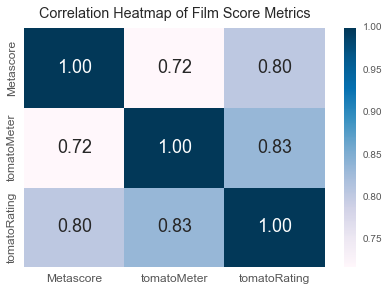

In [543]:
# Plot correlation heatmap
score_df = df[['Metascore', 'tomatoMeter', 'tomatoRating']]
plt.figure(figsize=(6,4))
ax = sns.heatmap(score_df.corr(), cmap='PuBu', annot=True, annot_kws={'size': 18}, \
                fmt='.2f')
ax.set_title('Correlation Heatmap of Film Score Metrics', y=1.02)
ax.tick_params(axis='both', labelsize=12)

In [587]:
score_df2 = df[['Metascore', 'tomatoMeter', 'tomatoRating', 
               'imdbRating', 'imdbVotes', 'tomatoFresh', 'tomatoRotten', 
               'tomatoUserMeter', 'tomatoUserRating']]
plt.figure(figsize=(16,8))
ax = sns.heatmap(score_df2.corr(), cmap='GnBu', annot=True, annot_kws={'size': 18}, \
                fmt='.2f')
ax.set_title('Correlation Heatmap of Film Score Metrics', y=1.02)
ax.set_xticklabels(score_df2.columns, rotation=45, horizontalalignment='right')
ax.tick_params(axis='both', labelsize=16, )

KeyError: "['Metascore'] not in index"

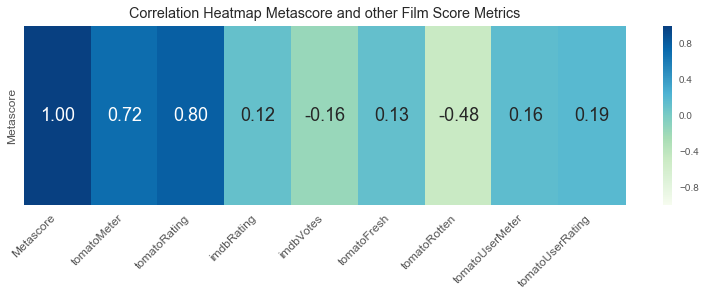

In [580]:
metascore_corr = score_df2.corr().ix[['Metascore']]
plt.figure(figsize=(12,3))
ax = sns.heatmap(metascore_corr, cmap='GnBu', annot=True, annot_kws={'size': 18}, \
                fmt='.2f')
ax.set_title('Correlation Heatmap Metascore and other Film Score Metrics', y=1.02)
ax.set_xticklabels(score_df2.columns, rotation=45, horizontalalignment='right')
ax.tick_params(axis='both', labelsize=12 )

In [570]:
# Drop Metascore as it is highly correlated to both tomatoMeter and tomatoRating
df.drop('Metascore', inplace=True, axis=1)

### Try to fill in missing values for Gross column with linear regression

In [571]:
summary = df.describe()
summary1 = pd.DataFrame(summary.loc[:, 'Gross'].apply(lambda x: '{0: ,.2f}'.format(x)))
summary1

,Gross
count,182.00
mean,"105,384,553.70"
std,"134,480,397.06"
min,"10,177.00"
25%,"8,072,547.75"
50%,"51,943,707.00"
75%,"162,003,486.00"
max,"936,627,416.00"


#### Unused pairplot

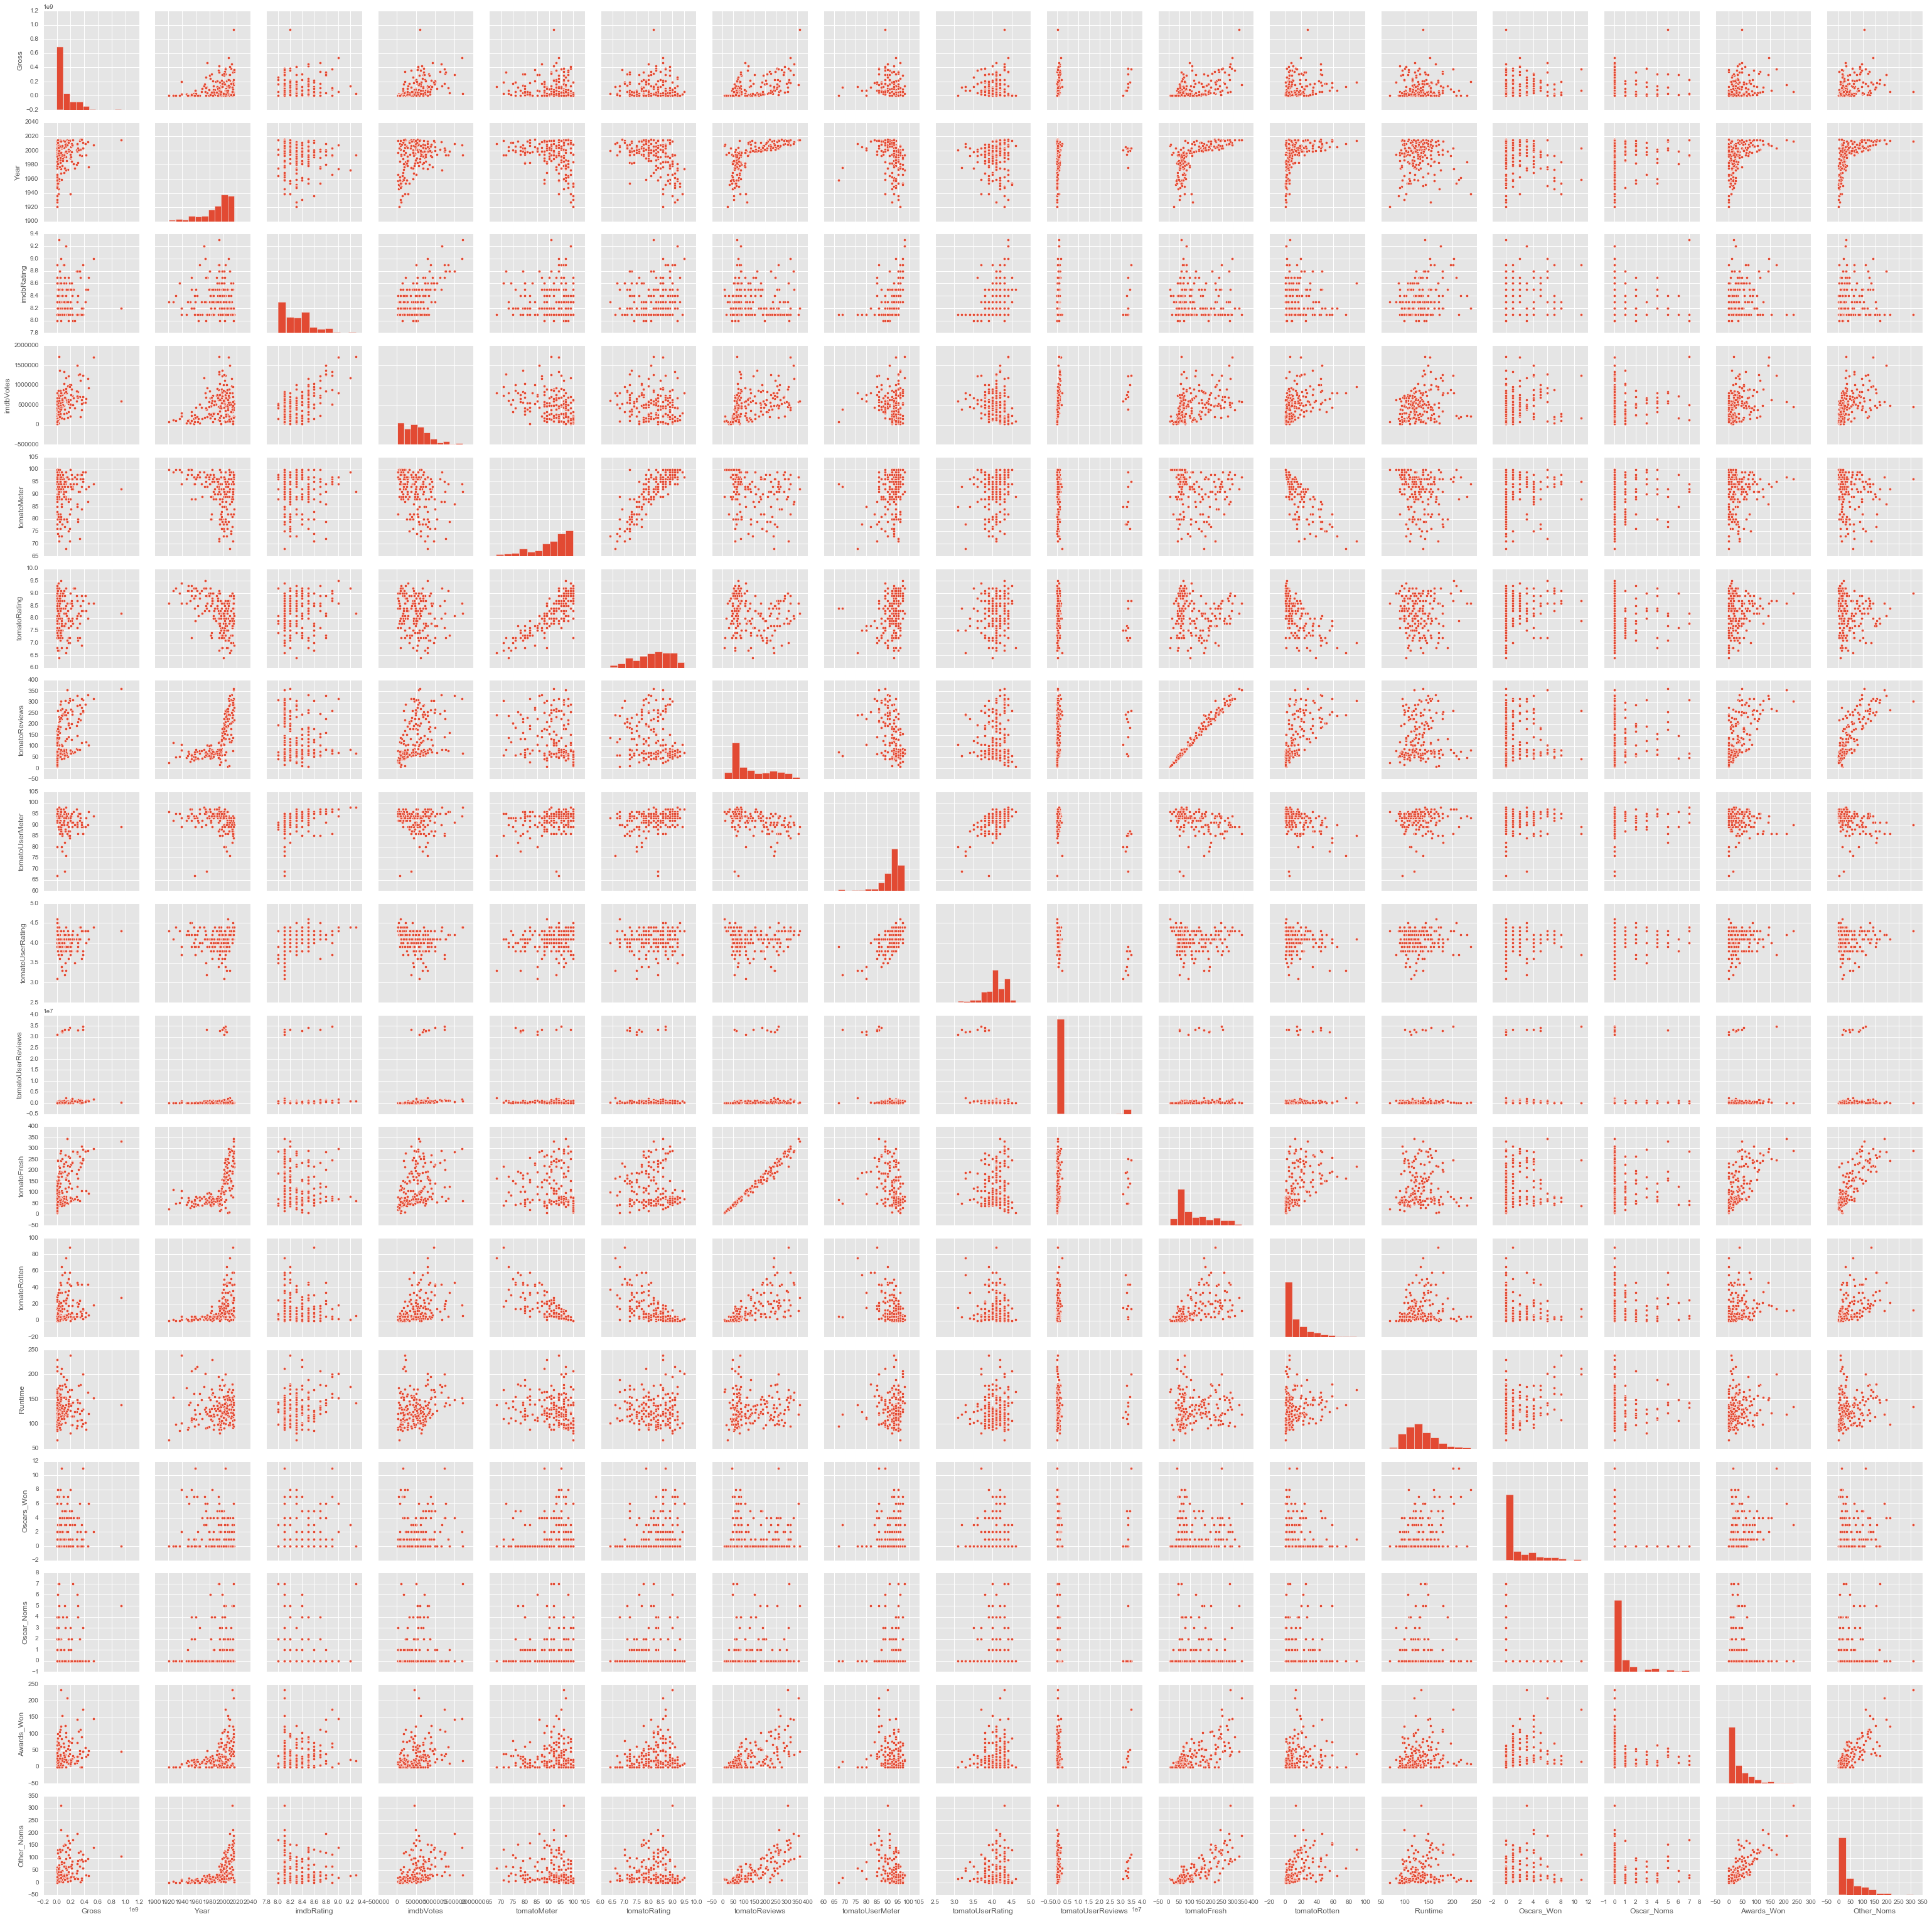

In [576]:
sns.pairplot(lm_test)

#### Heatmap

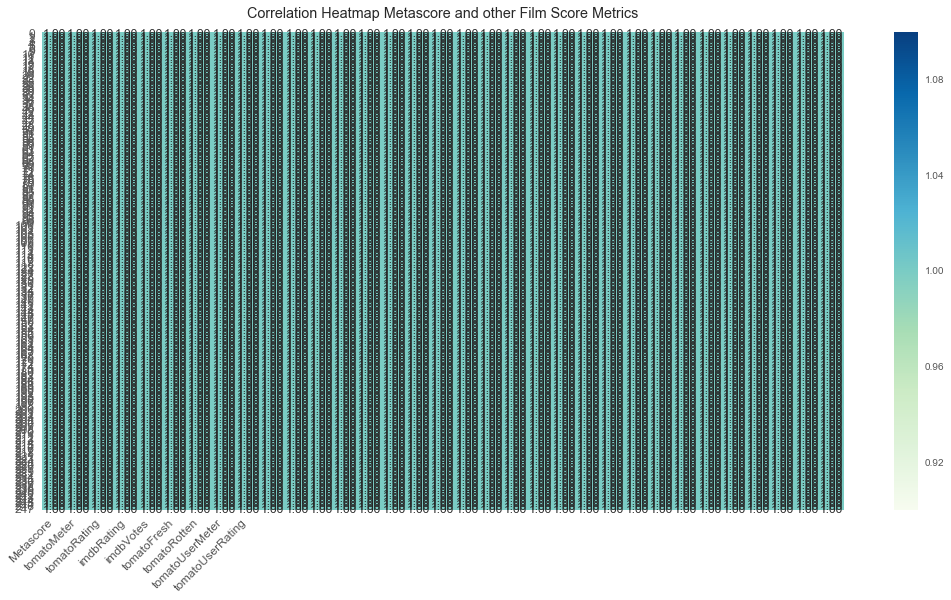

In [586]:
plt.figure(figsize=(16,8))
ax = sns.heatmap(lm_test.notnull(), cmap='GnBu', annot=True, annot_kws={'size': 12}, \
                fmt='.2f')
ax.set_title('Correlation Heatmap Metascore and other Film Score Metrics', y=1.02)
ax.set_xticklabels(score_df2.columns, rotation=45, horizontalalignment='right')
ax.tick_params(axis='both', labelsize=12 )


In [572]:
lm_test = df[df['Gross'].notnull() == True] 
lm_pred = df[df['Gross'].notnull() == False] 

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
lm = LinearRegression()
X = lm_test[['imdbRating', 'imdbVotes', 'tomatoMeter', \
              'tomatoRating', 'tomatoReviews', 'tomatoUserMeter', 'tomatoUserRating', \
              'tomatoUserReviews', 'tomatoFresh', 'tomatoRotten', 'Year', 'Oscars_Won', \
            'Oscar_Noms', 'Awards_Won', 'Other_Noms', 'Runtime']]
y = lm_test['Gross']

linear = lm.fit(X, y)
y_pred = linear.predict(X)


print 'model_score:', linear.score(X, y)
print 'MSE:', mean_squared_error(y, y_pred)
print 'coeffs: ', linear.coef_
print ''
print '***Note: Model score is too low to predict missing gross revenue values***'

model_score: 0.533361406244
MSE: 8.39277937845e+15
coeffs:  [ -1.43988228e+08   2.64905330e+02   1.44794871e+05  -1.44660917e+07
   1.46288719e+07  -1.90271076e+06   7.80562365e+07  -1.73755910e-01
  -1.33929154e+07  -1.68853278e+07  -3.34963771e+05   1.62857422e+07
   8.17524156e+06  -7.89301328e+05  -6.57694490e+05  -4.69445692e+04]

***Note: Model score is too low to predict missing gross revenue values***


#### Model score of 0.5319 is too low to predict missing gross values

### Fill in missing Gross values with median

In [ ]:
# Tried to fill in missing Gross values with BoxOffice values but no results

In [57]:
lm_test.corr().loc[:, ['Gross']]

,Gross
Gross,1.000000
Year,0.302139
imdbRating,0.110846
imdbVotes,0.505074
tomatoMeter,-0.047643
tomatoRating,-0.022033
tomatoReviews,0.527692
tomatoUserMeter,-0.159849
tomatoUserRating,-0.080927
tomatoUserReviews,0.159068


In [58]:
corr_index = lm_test.corr().loc['tomatoFresh', 'Gross']
corr_index
# Gross is most correlated with tomatoFresh

0.53979309291468913

In [59]:
df['Gross'].median()

51943707.0

In [60]:
# I attempted to standardize Gross and fill in for missing values by making
# an adjusted Gross column which is the Gross * corr_index or median Gross *
# corr_index for missing values (so Gross is represented in relation to corr_index)

gross_median = df['Gross'].median()
df['Adj_Gross'] = df['Gross'].apply(lambda x: x * corr_index if x > 0 else\
                                   gross_median * corr_index)

print df['Adj_Gross'].isnull().sum()
df['Adj_Gross'].head()

0


0    7.066971e+06
1    1.452373e+05
2    1.308321e+08
3    1.468237e+07
4    6.502671e+05
Name: Adj_Gross, dtype: float64

## Count Vectorization

In [ ]:
# Actor, Director, Plot, Title, Genre, Production

In [61]:
# CountVectorizer w/parameters
cvec = CountVectorizer(stop_words='english', lowercase=True, \
                      max_features=25, binary=True)

"""I chose to limit max features to 25 because:
1. Avoid overfitting: In a dataset with only 250 rows, 
I don't want to blow up features (curse of dimensionality?) 
2. Operational efficiency: Processing time too slow with too many features)"""

#### Language

In [ ]:
# lang_df = cvec.fit_transform(df['Language']).todense()
# lang_col = cvec.get_feature_names()
# lang_df = pd.DataFrame(lang_df, columns=lang_col)

# language = pd.DataFrame(lang_df.sum())
# language.columns = ['Count']
# language.sort_values(['Count'], ascending=False, inplace=True)
# language

#### Actors

In [62]:
# Create column of first names only
df['Actor_First_Name'] = df['Actors'].apply(lambda x: x.split(',')[0])
df['Actor_First_Name'] = df['Actors'].apply(lambda x: x.split(' ')[0])
print df['Actor_First_Name'].head(3)

# Create column of lead actors only
df['Lead_Actor'] = df['Actors'].apply(lambda x: x.split(',')[0])
print df['Lead_Actor'].head(3)

# Create column of concatenated names to identify unique people
df['Actors'] = df['Actors'].apply(lambda x: x.replace(' ',''))
print df['Actors'].head(3)

0       Miles
1     Toshirô
2    Harrison
Name: Actor_First_Name, dtype: object
0      Miles Teller
1    Toshirô Mifune
2     Harrison Ford
Name: Lead_Actor, dtype: object
0    MilesTeller,J.K.Simmons,PaulReiser,MelissaBenoist
1    ToshirôMifune,TakashiShimura,KeikoTsushima,Yuk...
2      HarrisonFord,KarenAllen,PaulFreeman,RonaldLacey
Name: Actors, dtype: object


In [65]:
actors_df.shape

(250, 25)

In [64]:
actors_df = cvec.fit_transform(df['Actors']).todense()
actor_col = cvec.get_feature_names()
actors_df = pd.DataFrame(actors_df, columns=actor_col)

actors = pd.DataFrame(actors_df.sum())
actors.columns = ['Count']
actors.sort_values(['Count'], ascending=False, inplace=True)
actors.head()

,Count
leonardodicaprio,7
robertdeniro,7
harrisonford,7
tomhanks,6
clinteastwood,6


4    9
3    9
7    3
6    2
5    2
Name: Count, dtype: int64
(16, 1)
                  Count
tomhanks              6
clinteastwood         6
leonardodicaprio      7
robertdeniro          7
harrisonford          7


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


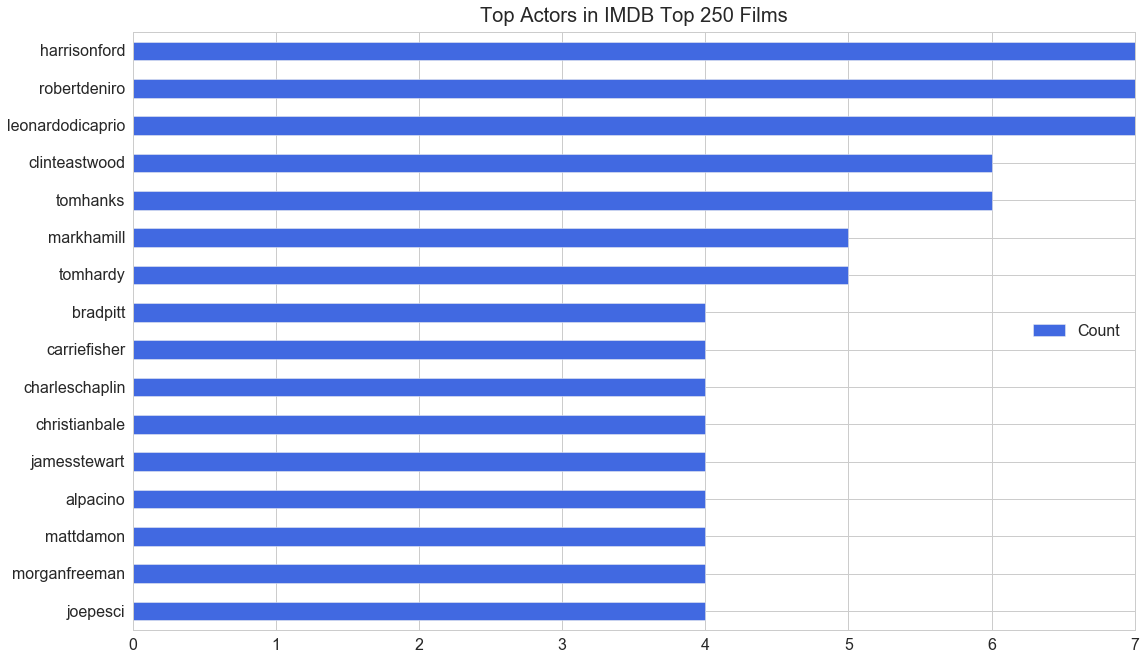

In [67]:
print actors['Count'].value_counts()
top_actors = actors[actors['Count'] > 3]
top_actors.sort_values('Count', ascending=True, inplace=True)
print top_actors.shape
print top_actors.tail()

ax = top_actors.plot(kind='barh', figsize=(16,10), color='royalblue')
ax.set_title('Top Actors in IMDB Top 250 Films', y=1.01)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc='center right')

          Count
james         4
clint         5
robert        5
leonardo      6
tom           8
3    16
4     4
5     2
8     1
6     1
2     1
Name: Count, dtype: int64


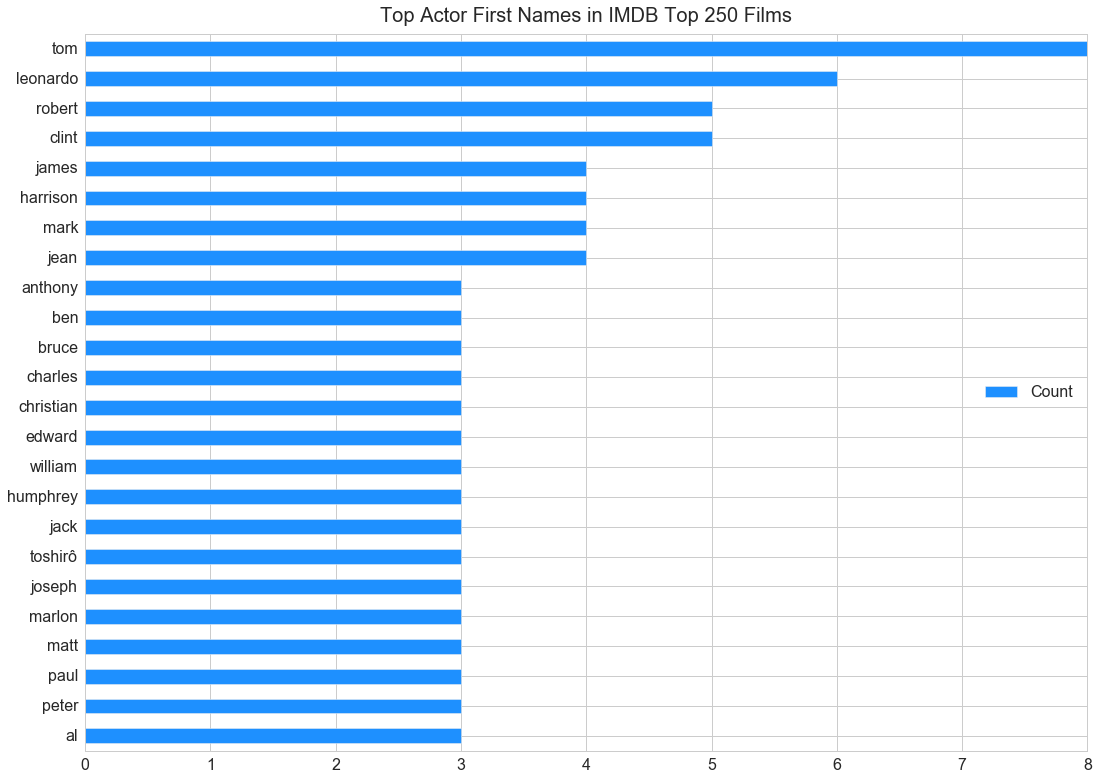

In [68]:
actor_first = cvec.fit_transform(df['Actor_First_Name']).todense()
actor_first_col = cvec.get_feature_names()
actor_first = pd.DataFrame(actor_first, columns=actor_first_col)

actor_first = pd.DataFrame(actor_first.sum())
actor_first.columns = ['Count']
actor_first.sort_values(['Count'], inplace=True)
print actor_first.tail()
print actor_first['Count'].value_counts()

top_actor_first = actor_first[actor_first['Count'] > 2]

"""self, x=None, y=None, kind='line', ax=None, subplots=False, sharex=None, \
sharey=False, layout=None, figsize=None, use_index=True, title=None, \
grid=None, legend=True, style=None, logx=False, logy=False, loglog=False, \
xticks=None, yticks=None, xlim=None, ylim=None, rot=None, fontsize=None, \
colormap=None, table=False, yerr=None, xerr=None, secondary_y=False, \
sort_columns=False, **kwds"""

ax = top_actor_first.plot(kind='barh', figsize=(16,12), color='dodgerblue')
ax.set_title('Top Actor First Names in IMDB Top 250 Films', y=1.01)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc='center right')

#### Unused Categorical Histograms

In [ ]:
# Ask how to create barh subplots with categorical histograms

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,30), sharex=True)

ax1.barh( color='royalblue')
ax1.set_title('Top Actors in IMDB Top 250 Films', y=1.01)
ax1.tick_params(labelsize=16)
ax1.legend(fontsize=16, loc='center right')

ax2 = top_actor_first.plot(kind='barh', figsize=(16,12), color='dodgerblue')
ax2.set_title('Top Actor First Names in IMDB Top 250 Films', y=1.01)
ax2.tick_params(labelsize=16)
ax2.legend(fontsize=16, loc='center right')

#### Directors 

3    12
7     5
5     4
6     2
4     2
Name: Count, dtype: int64
(13, 1)
                  Count
stevenspielberg       7
christophernolan      7
martinscorsese        7
alfredhitchcock       7
stanleykubrick        7


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


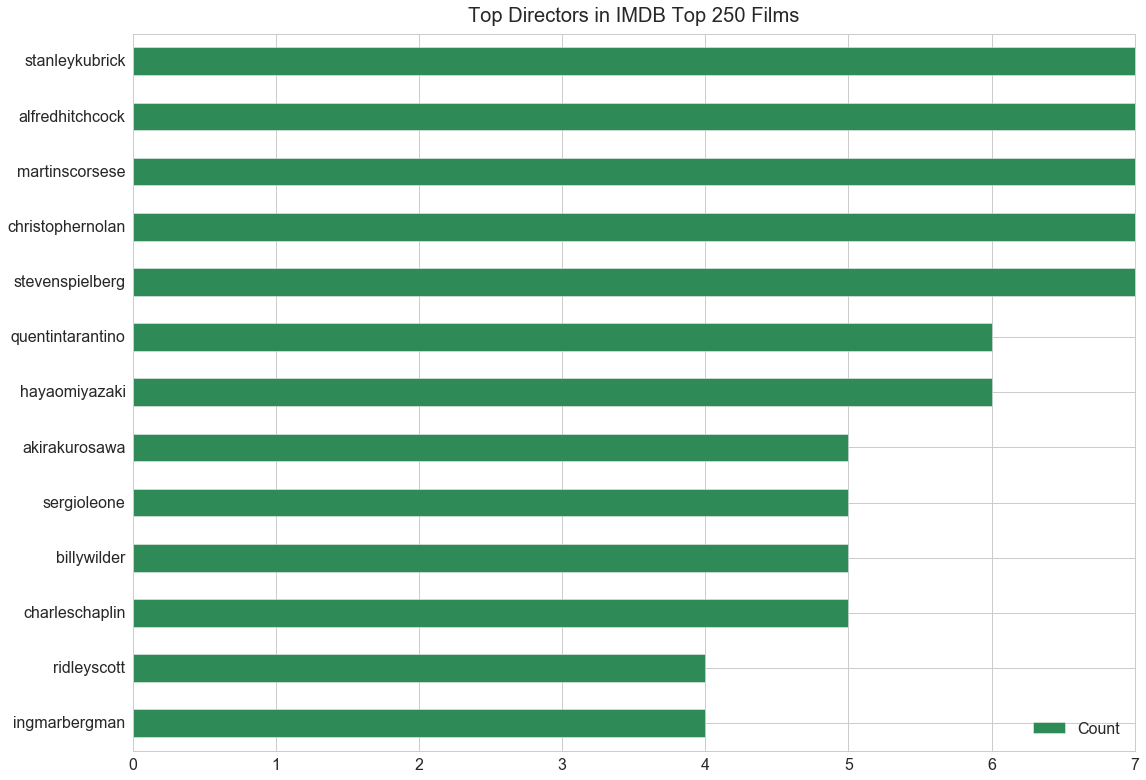

In [70]:
# Create column of concatenated directors to identify unique people
df['Director'] = df['Director'].apply(lambda x: x.replace(' ',''))

directors_df = cvec.fit_transform(df['Director']).todense()
directors_col = cvec.get_feature_names()
directors_df = pd.DataFrame(directors_df, columns=directors_col)
directors = pd.DataFrame(directors_df.sum())
directors.columns = ['Count']
directors.sort_values(['Count'], inplace=True)

print directors['Count'].value_counts()
top_directors = directors[directors['Count'] > 3]
top_directors.sort_values('Count', inplace=True)
print top_directors.shape
print top_directors.tail()

ax = top_directors.plot(kind='barh', figsize=(16,12), color='seagreen')
ax.set_title('Top Directors in IMDB Top 250 Films', y=1.01)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc='lower right')

#### Plot

(25, 1)
        Count
story      23
father     24
time       25
police     26
war        28
new        31
man        36
young      39
world      40
life       49


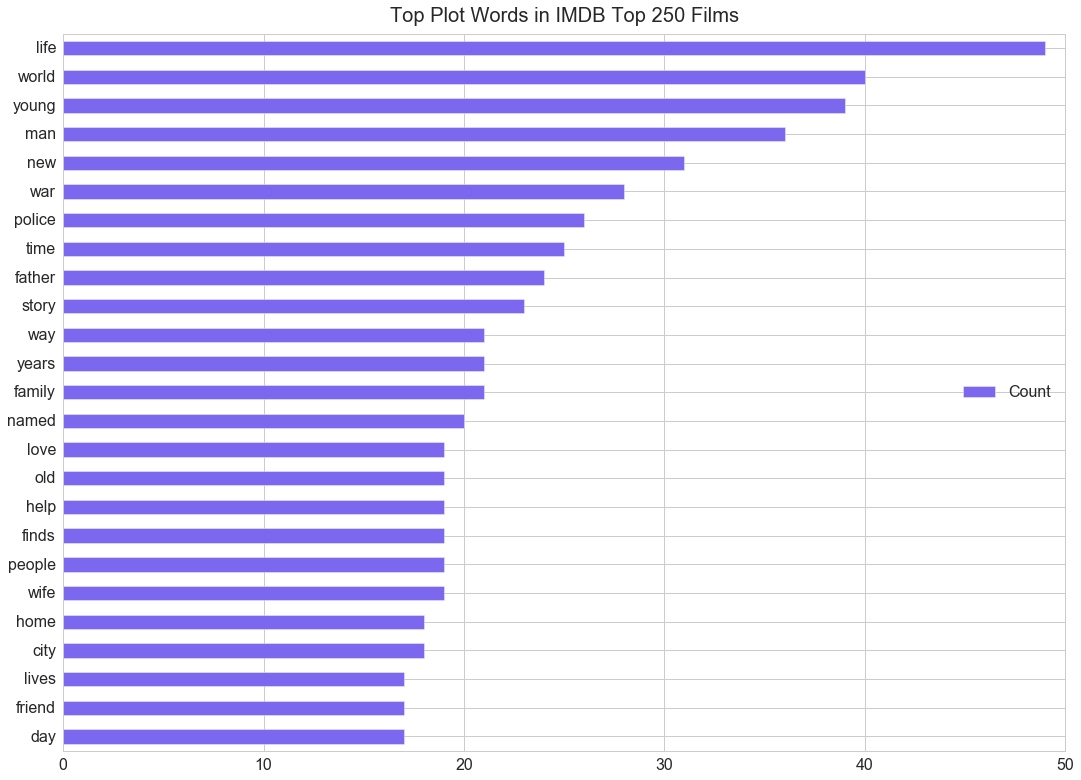

In [71]:
plot_df = cvec.fit_transform(df['Plot']).todense()
plot_col = cvec.get_feature_names()
plot_df = pd.DataFrame(plot_df, columns=plot_col)
plot = pd.DataFrame(plot_df.sum())
plot.columns = ['Count']
plot.sort_values(['Count'], inplace=True)
plot['Count'].value_counts().sort_values(ascending=True)

# print plot['Count'].value_counts()
top_plot = plot[plot['Count'] > 15]
top_plot.sort_values('Count', inplace=True)
print top_plot.shape
print top_plot.tail(10)

ax = top_plot.plot(kind='barh', figsize=(16,12), color='mediumslateblue')
ax.set_title('Top Plot Words in IMDB Top 250 Films', y=1.01)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc='center right')

#### Title

(25, 1)
         Count
city         3
day          3
episode      3
man          3
rings        3
lord         3
life         3
story        3
wars         4
star         4


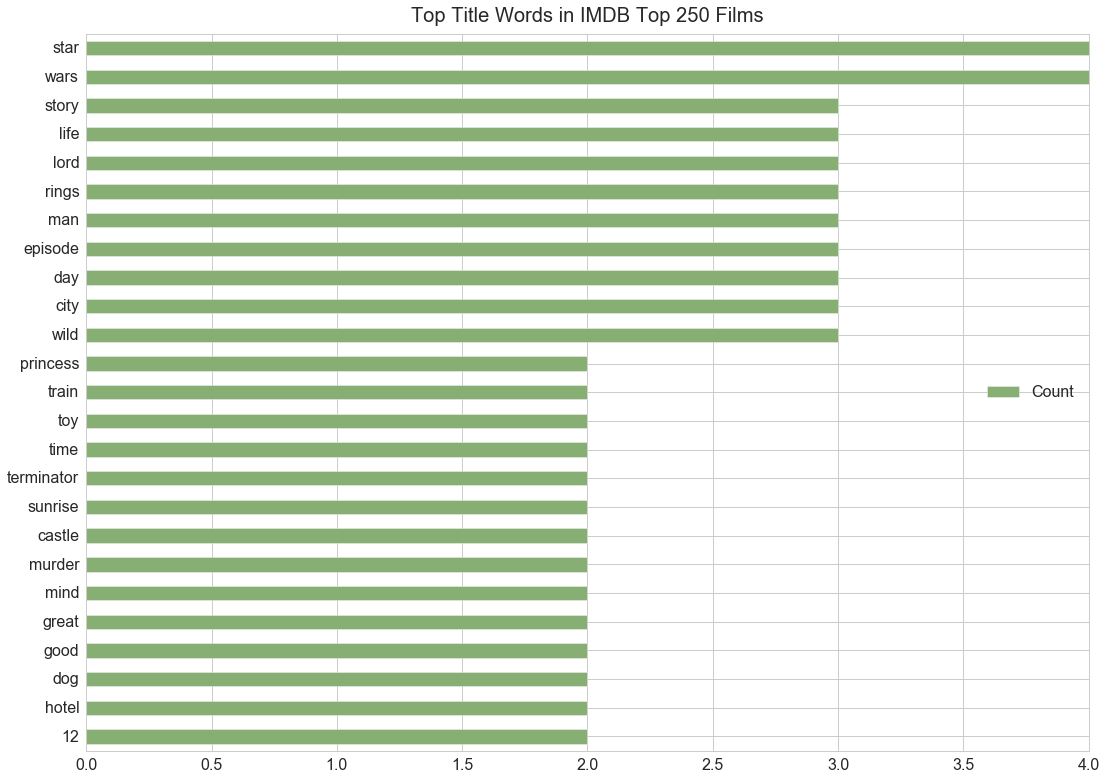

In [72]:
title_df = cvec.fit_transform(df['Title']).todense()
title_col = cvec.get_feature_names()
title_df = pd.DataFrame(title_df, columns=title_col)
title = pd.DataFrame(title_df.sum())
title.columns = ['Count']
title.sort_values(['Count'], inplace=True)
title['Count'].value_counts().sort_values(ascending=True)

# print plot['Count'].value_counts()
top_title = title[title['Count'] > 1]
top_title.sort_values('Count', inplace=True)
print top_title.shape
print top_title.tail(10)

ax = top_title.plot(kind='barh', figsize=(16,12), color='sage')
ax.set_title('Top Title Words in IMDB Top 250 Films', y=1.01)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc='center right')

#### Genre

(23, 1)
           Count
sci           22
fantasy       23
biography     25
mystery       30
action        35
thriller      41
comedy        43
crime         57
adventure     61
drama        172


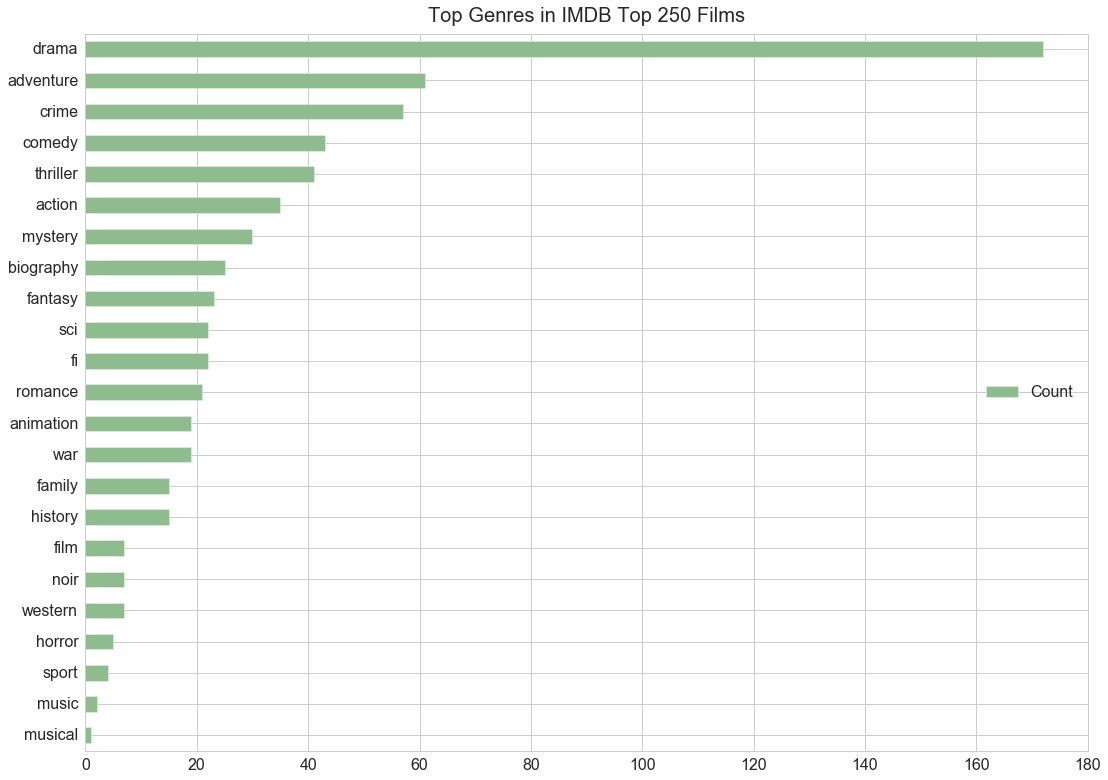

In [73]:
genre_df = cvec.fit_transform(df['Genre']).todense()
genre_col = cvec.get_feature_names()
genre_df = pd.DataFrame(genre_df, columns=genre_col)
genre = pd.DataFrame(genre_df.sum())
genre.columns = ['Count']
genre.sort_values(['Count'], inplace=True)
genre['Count'].value_counts().sort_values(ascending=True)

# print plot['Count'].value_counts()
top_genre = genre[genre['Count'] > 0]
top_genre.sort_values('Count', inplace=True)
print top_genre.shape
print top_genre.tail(10)

ax = top_genre.plot(kind='barh', figsize=(16,12), color='darkseagreen')
ax.set_title('Top Genres in IMDB Top 250 Films', y=1.01)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc='center right')

#### Production Company

0    SonyPicturesClassics
1        ColumbiaPictures
2       ParamountPictures
Name: Production, dtype: object
(19, 1)
                    Count
mgm                     6
waltdisneypictures      7
miramaxfilms           10
columbiapictures       10
20thcenturyfox         11
universalpictures      12
unitedartists          13
paramountpictures      18
pictures               21
warnerbros             30


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


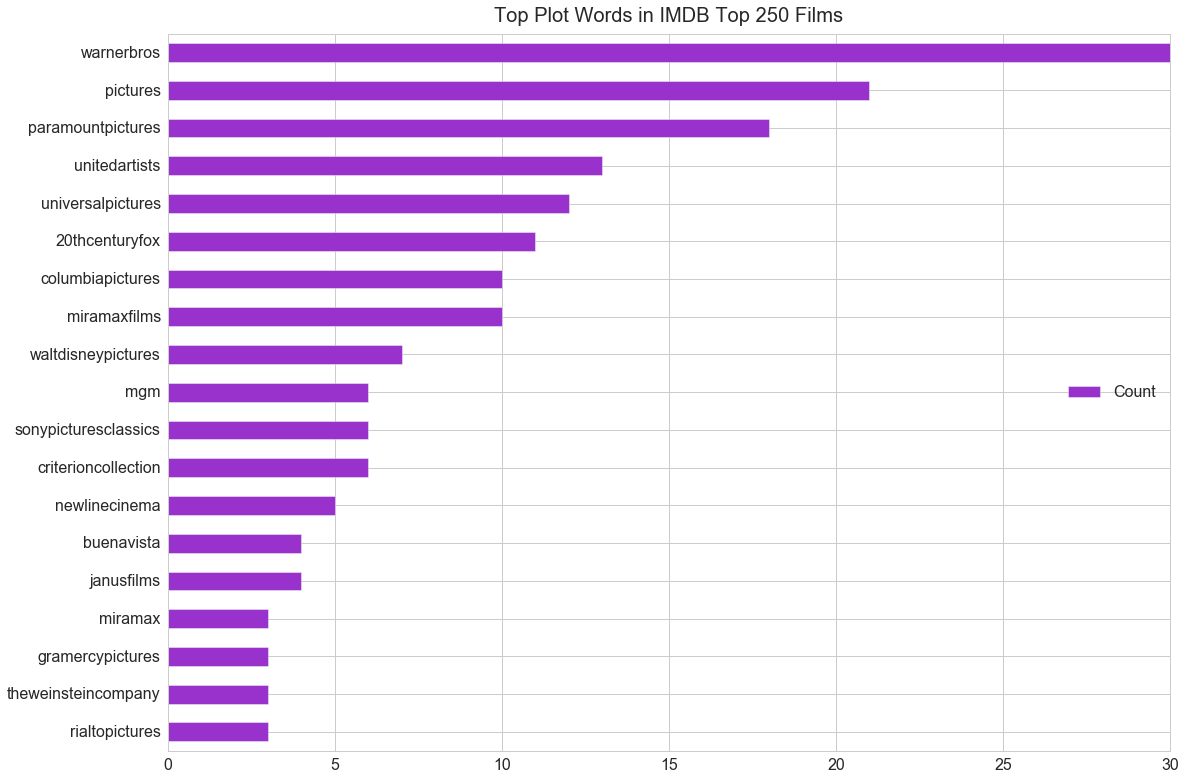

In [74]:
# Create column of concatenated production company names to identify unique companies
df['Production'] = df['Production'].apply(lambda x: x.replace(' ',''))
print df['Production'].head(3)

production_df = cvec.fit_transform(df['Production']).todense()
production_col = cvec.get_feature_names()
production_df = pd.DataFrame(production_df, columns=production_col)
production = pd.DataFrame(production_df.sum())
production.columns = ['Count']
production.sort_values(['Count'], inplace=True)
production['Count'].value_counts().sort_values(ascending=True)

# print production['Count'].value_counts()
top_production = production[production['Count'] > 2]
top_production.sort_values('Count', inplace=True)
print top_production.shape
print top_production.tail(10)

ax = top_production.plot(kind='barh', figsize=(16,12), color='darkorchid')
ax.set_title('Top Plot Words in IMDB Top 250 Films', y=1.01)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc='center right')

### New dataframes for limited top categorical columns

In [75]:
print top_actors.shape
print top_directors.shape
print top_plot.shape
print top_title.shape
print top_genre.shape
print top_production.shape

(16, 1)
(13, 1)
(25, 1)
(25, 1)
(23, 1)
(19, 1)


## EDA

### Histograms

#### Year, Runtime, Gross

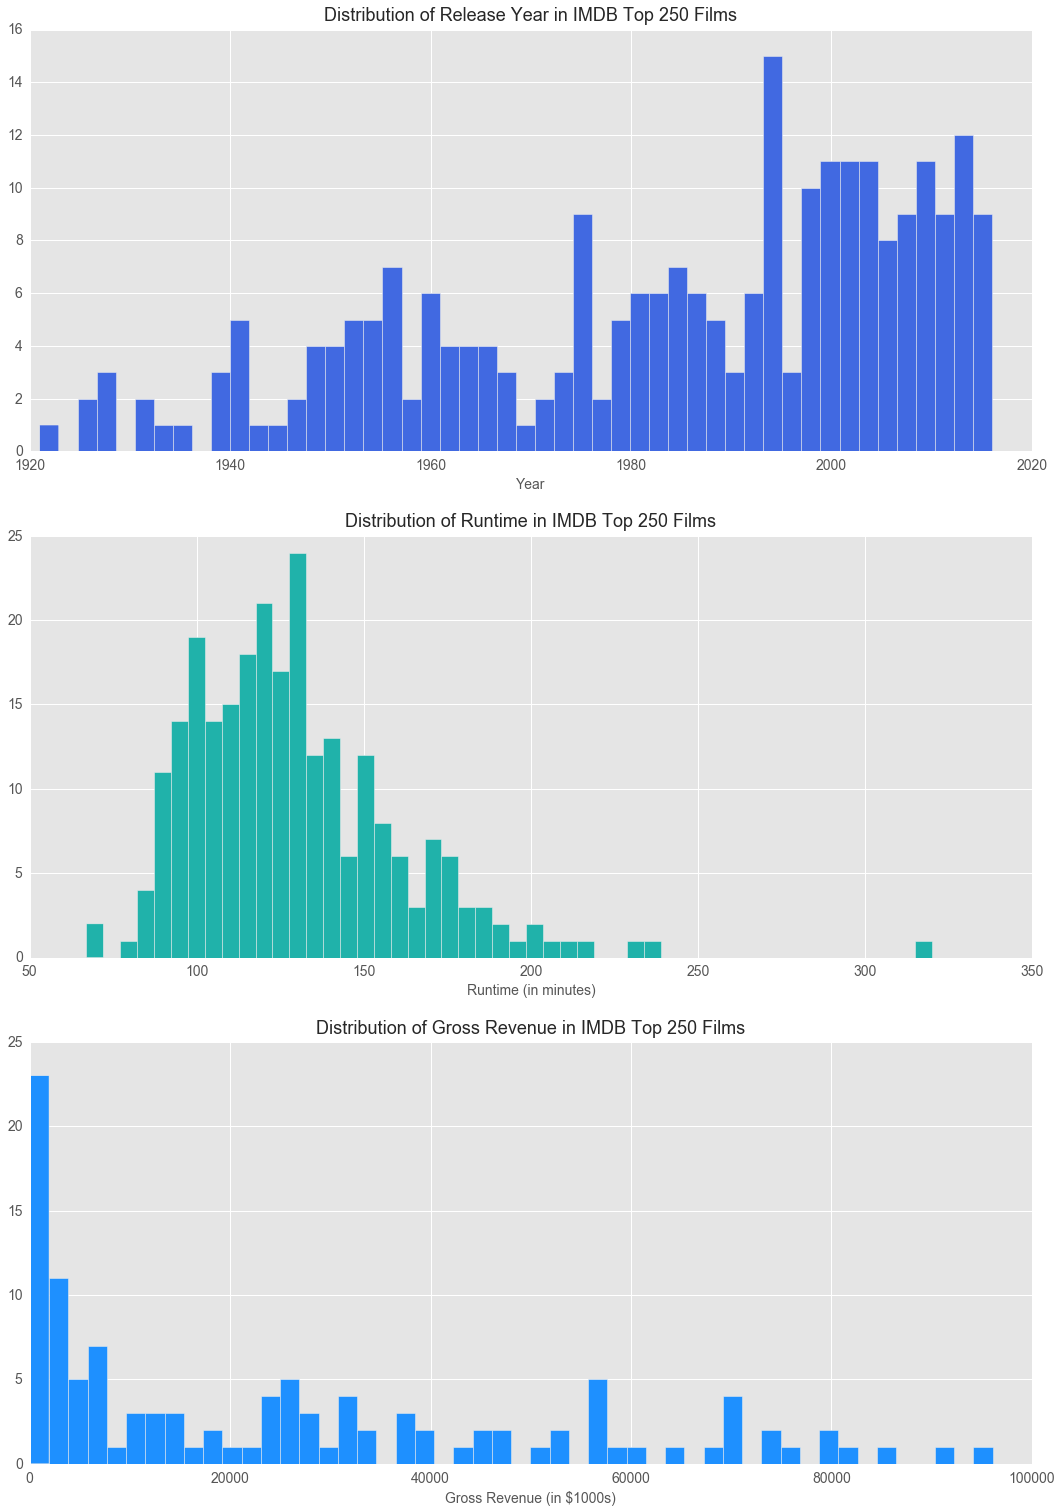

In [77]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(16,24))

ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

ax1.hist(df['Year'], bins=50, color='royalblue')
ax1.set_title('Distribution of Release Year in IMDB Top 250 Films', \
             fontsize=18, y=1.01)
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylim(top=16)
ax1.tick_params(labelsize=14)

ax2.hist(df['Runtime'], bins=50, color='lightseagreen')
ax2.set_title('Distribution of Runtime in IMDB Top 250 Films', \
             fontsize=18, y=1.01)
ax2.set_xlabel('Runtime (in minutes)', fontsize=14)
ax2.tick_params(labelsize=14)

gross_hist = df[df['Gross'] < 100000000]
gross_hist = gross_hist[gross_hist['Gross'] > 0]
ax3.hist(gross_hist['Gross']/1000, bins=50, color='dodgerblue')
ax3.set_title('Distribution of Gross Revenue in IMDB Top 250 Films', \
             fontsize=18, y=1.01)
ax3.set_xlabel('Gross Revenue (in $1000s)', fontsize=14, y = -2.01)
ax3.tick_params(labelsize=14)

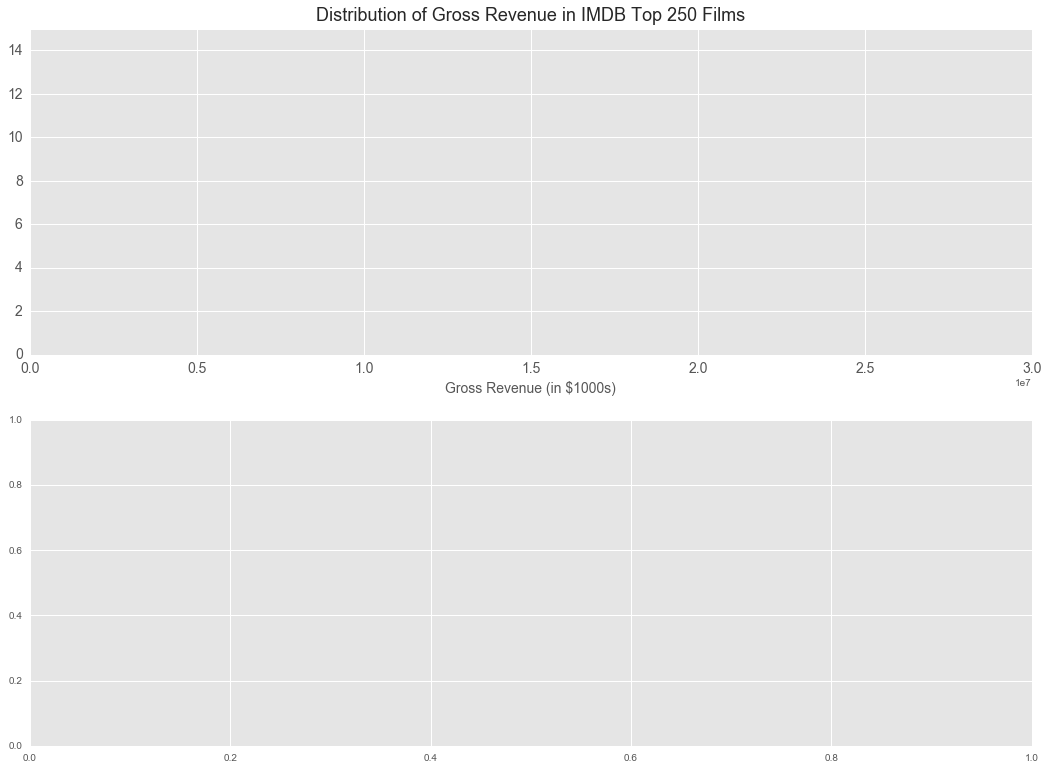

In [79]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)


gross_hist = df[df['Gross'] < 10000000]
gross_hist = gross_hist[gross_hist['Gross'] > 0]
ax1.hist(gross_hist['Gross']/1000, bins=25, color='dodgerblue')
ax1.set_title('Distribution of Gross Revenue in IMDB Top 250 Films', \
             fontsize=18, y=1.01)
ax1.set_xlabel('Gross Revenue (in $1000s)', fontsize=14, y = -2.01)
ax1.set_ylim(top=15)
ax1.tick_params(labelsize=14)
ax1.axvline(x=((gross_median*corr_index)),ymin=0,ymax=None,\
            c="red",linewidth=5,zorder=0)


#### Reviews

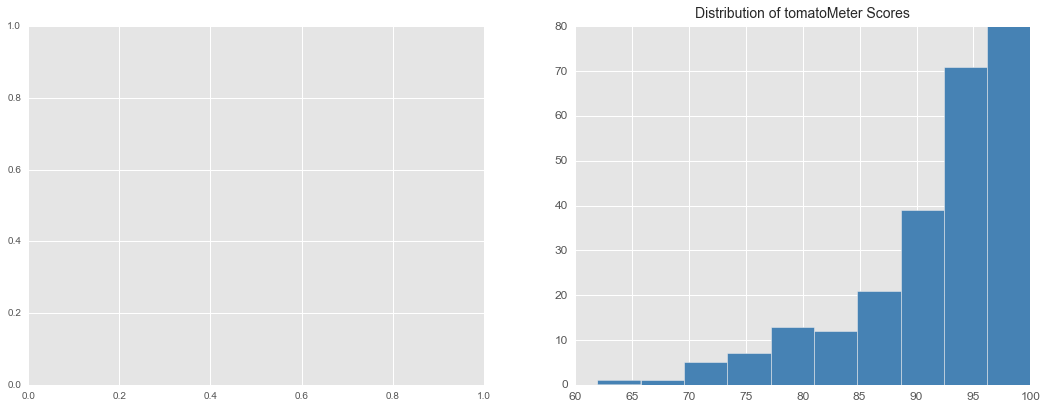

In [80]:
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(16,6))

# metascore = df[df['Metascore'] > 0]
# ax1.hist(metascore['Metascore'], color='royalblue')
# ax1.set_title('Distribution of Metascores', \
#              fontsize=14, y=1.01)
# ax1.tick_params(labelsize=12)

tomatoMeter = df[df['tomatoMeter'] > 0]
ax2.hist(tomatoMeter['tomatoMeter'], color='steelblue')
ax2.set_title('Distribution of tomatoMeter Scores', \
             fontsize=14, y=1.01)
ax2.tick_params(labelsize=12)

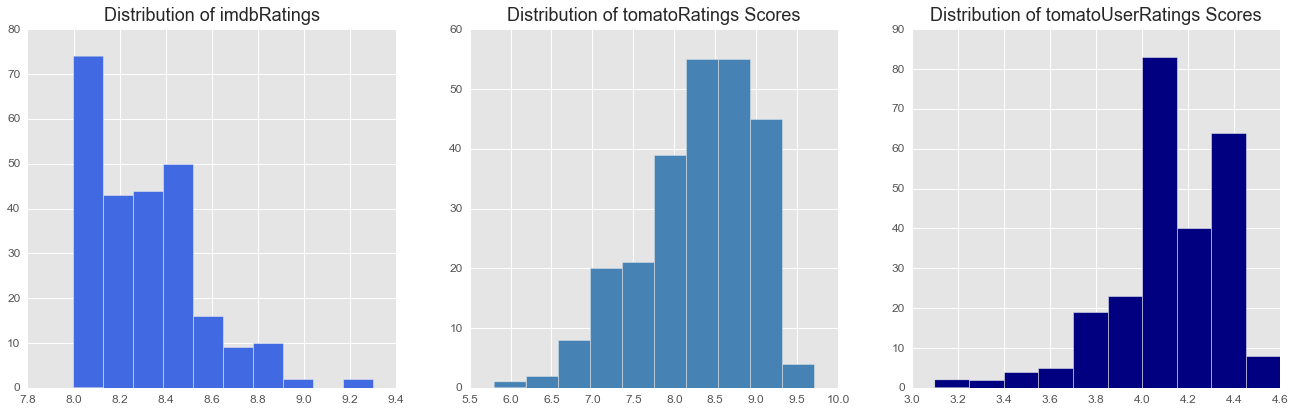

In [81]:
plt.style.use('ggplot')
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,figsize=(20,6))

imdbRating = df[df['imdbRating'] > 0]
ax1.hist(df['imdbRating'], color='royalblue')
ax1.set_title('Distribution of imdbRatings', \
             fontsize=18, y=1.01)
ax1.tick_params(labelsize=12)

tomatoRating = df[df['tomatoRating'] > 0]
ax2.hist(tomatoMeter['tomatoRating'], color='steelblue')
ax2.set_title('Distribution of tomatoRatings Scores', \
             fontsize=18, y=1.01)
ax2.tick_params(labelsize=12)

tomatoRating = df[df['tomatoRating'] > 0]
ax2.hist(tomatoMeter['tomatoRating'], color='steelblue')
ax2.set_title('Distribution of tomatoRatings Scores', \
             fontsize=18, y=1.01)


tomatoUserRating = df[df['tomatoUserRating'] > 0]
ax3.hist(tomatoMeter['tomatoUserRating'], color='navy')
ax3.set_title('Distribution of tomatoUserRatings Scores', \
             fontsize=18, y=1.01)
ax3.tick_params(labelsize=12)

### Scatterplots

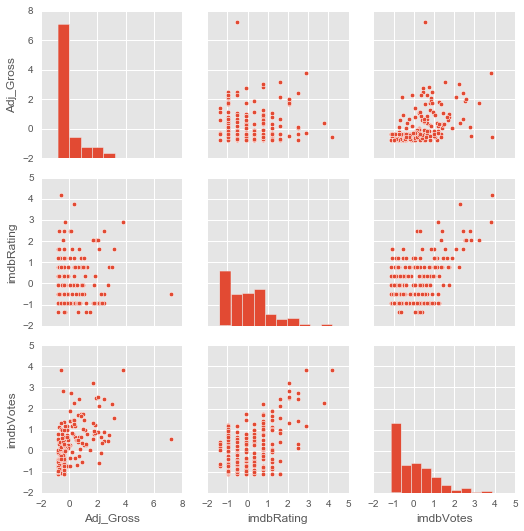

In [520]:
pairplot_cols = ['Adj_Gross', 'imdbRating', 'imdbVotes']
pairplot_df = df.loc[:, pairplot_cols]
sns.pairplot(pairplot_df)
# Not much of a relationship between target and gross (as I would've guessed)

### Unused Separate Histograms

In [ ]:
bins_dict = {'Year': 50, 'Runtime': 50, 'imdbRating': 50}
facecolor_dict = {'Year': 'royalblue', 'Runtime': 'coral', 'imdbRating': 'lightseagreen'}
axis_titles = {'Year': 'Distribution of Years in IMDB Top 250 Films',
              'Runtime': 'Distribution of Runtime in IMDB Top 250 Films',
              'imdbRating': 'Distribution of Years in IMDB Top 250 Films'}
#data, column=None, by=None, grid=True, xlabelsize=None, 
#xrot=None, ylabelsize=None, yrot=None, ax=None, sharex=False, 
#sharey=False, figsize=None, layout=None, bins=10, **kwds)¶
xlabel = 14
ylabel = 14
year_bins = 50
df['Year'].hist(figsize=(16,4),xlabelsize=xlabel, ylabelsize=ylabel, bins=bins_dict['Year'],
               facecolor=facecolor_dict['Year'], alpha = .85)

In [ ]:
bins_dict = {'Year': 50, 'Runtime': 50, 'imdbRating': 50}
facecolor_dict = {'Year': 'royalblue', 'Runtime': 'coral', 'imdbRating': 'lightseagreen'}
axis_titles = {'Year': 'Distribution of Years in IMDB Top 250 Films',
              'Runtime': 'Distribution of Runtime in IMDB Top 250 Films',
              'imdbRating': 'Distribution of Years in IMDB Top 250 Films'}


def hist_plot(x):
    fig = plt.figure(figsize=(16,6))
    ax = fig.add_subplot(111)
    n, bins, patches = ax.hist(x,  bins=bins_dict[x], facecolor=facecolor_dict[x], alpha=0.85)
    ax.set_title(axis_titles[x], fontsize=20, y=1.02)
    #ax.set_xticklabels(labels, fontsize=16)
    #ax.set_xticks(labels)
    #ax.set_ylim(0, 16)
    #y_labels = [i for i in range(18) if i%2 == 0]
    #ax.set_yticklabels(y_labels, fontsize=16)

In [ ]:
# Years
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(df['Year'],  bins=50, facecolor='royalblue', alpha=0.85)

def decades():
    i = 1910
    labels = []
    while i < 2020:
        labels.append(i + 10)
        i += 10
    return labels
labels = decades()

ax.set_title('Distribution of Years in IMDB Top 250 Films', fontsize=20, y=1.02)
ax.set_xticklabels(labels, fontsize=16)
ax.set_xticks(labels)
ax.set_ylim(0, 16)
y_labels = [i for i in range(18) if i%2 == 0]
ax.set_yticklabels(y_labels, fontsize=16)

In [ ]:
# Runtime
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(df['Runtime'],  bins=50, facecolor='coral', alpha=0.85)

ax.set_title('Distribution of Runtime in IMDB Top 250 Films', fontsize=20, y=1.02)

## Standardizing and Dummies

### Use StandardScaler to standardize numerical data

In [82]:
# Isolate numeric columns for standardizing
number_cols = [i for i in df.columns if df[i].dtype == 'float64' \
              or df[i].dtype == 'int']
number_cols.remove('Gross')
number_cols

['Year',
 'imdbRating',
 'imdbVotes',
 'tomatoMeter',
 'tomatoRating',
 'tomatoReviews',
 'tomatoUserMeter',
 'tomatoUserRating',
 'tomatoUserReviews',
 'tomatoFresh',
 'tomatoRotten',
 'Runtime',
 'Oscars_Won',
 'Oscar_Noms',
 'Awards_Won',
 'Other_Noms',
 'Adj_Gross']

In [83]:
# Standardize numeric columns
standardscaler = StandardScaler()
df.loc[:, number_cols] = standardscaler.fit_transform(df[number_cols])

In [504]:
df[['imdbRating', 'tomatoRating', 'tomatoUserRating', 'tomatoMeter']].head()

,imdbRating,tomatoRating,tomatoUserRating,tomatoMeter
0,0.770426,0.431387,1.647332,0.267900
1,1.628362,1.432616,1.647332,1.088000
2,0.770426,1.289583,0.000000,0.267900
3,-0.516477,1.289583,-0.411833,0.267900
4,0.770426,-2.143203,2.059166,-0.415518


### Create dummy variables

In [85]:
# Create dummy variables for rated column
rated = pd.get_dummies(df['Rated'], prefix='Rated')
rated.head(3)

,Rated_G,Rated_OTHER,Rated_PG,Rated_PG-13,Rated_R
0,0,0,0,0,1
1,0,1,0,0,0
2,0,0,1,0,0


In [86]:
# Create dummy variables for genre column
genre = pd.get_dummies(df['Genre_1'], prefix='Genre')
genre.head(3)

,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Biography,Genre_Comedy,Genre_Crime,Genre_Drama,Genre_Film-Noir,Genre_Horror,Genre_Mystery,Genre_Sci-Fi,Genre_Western
0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0


In [87]:
# Create dummy variables for genre column
season = pd.get_dummies(df['Season'], prefix='Season')
season.head(3)

,Season_Fall,Season_Holiday,Season_Summer,Season_Winter
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0


In [88]:
# Create dummy variables for month column
month = pd.get_dummies(df['Month'], prefix='Month')
month.head(3)

,Month_,Month_Apr,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0


### Create a new model_df by concatenating other dataframes together

In [ ]:
# list of dataframes:
"""
df
actors_df
directors_df
plot_df
title_df
genre_df
production_df
rated
genre
season
month
"""

In [89]:
model_df = df[['Year', 'Released', 'imdbRating', 'imdbVotes', \
             'tomatoMeter', 'tomatoRating', 'tomatoReviews', \
             'tomatoUserMeter', 'tomatoUserRating', 'tomatoUserReviews', \
             'tomatoFresh', 'tomatoRotten', 'Runtime', \
              'Oscars_Won', 'Awards_Won', 'Oscar_Noms', 'Other_Noms', \
             'Adj_Gross']]
model_df.head(2)

,Year,Released,imdbRating,imdbVotes,tomatoMeter,tomatoRating,tomatoReviews,tomatoUserMeter,tomatoUserRating,tomatoUserReviews,tomatoFresh,tomatoRotten,Runtime,Oscars_Won,Awards_Won,Oscar_Noms,Other_Noms,Adj_Gross
0,1.238348,2014-10-15,0.770426,0.021450,0.2679,0.431387,1.726528,0.423738,1.647332,-0.239997,1.875754,0.304953,-0.694059,0.728251,1.669233,-0.483864,2.047323,-0.665315
1,-1.242649,1956-11-19,1.628362,-0.513096,1.0880,1.432616,-0.637626,1.159394,1.647332,-0.236394,-0.577586,-0.725294,2.432333,-0.651013,-0.581591,0.750482,-0.619018,-0.775033


In [92]:
print 'df', df.shape
print 'actors_df', actors_df.shape
print 'directors_df', directors_df.shape
print 'plot_df', plot_df.shape
print 'title_df', title_df.shape
print 'genre_df', genre_df.shape
print 'production_df', production_df.shape
print 'rated', rated.shape
print 'genre', genre.shape
print 'season', season.shape
print 'month', month.shape

df (250, 36)
actors_df (250, 25)
directors_df (250, 25)
plot_df (250, 25)
title_df (250, 25)
genre_df (250, 23)
production_df (250, 25)
rated (250, 5)
genre (250, 12)
season (250, 4)
month (250, 13)


In [ ]:
# model_df = pd.concat([model_df, actors_df, directors_df, plot_df, title_df, \
#                      genre_df, production_df, rated, genre, season], axis=1)
# print model_df.shape
# model_df.head(2)

In [93]:
model_df1 = pd.concat([model_df, actors_df, directors_df, plot_df, title_df,
                      genre_df, production_df, rated, genre, season, month], 
                      axis=1)
print model_df1.shape
model_df1.head(2)

(250, 200)


,Year,Released,imdbRating,imdbVotes,tomatoMeter,tomatoRating,tomatoReviews,tomatoUserMeter,tomatoUserRating,tomatoUserReviews,...,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
0,1.238348,2014-10-15,0.770426,0.021450,0.2679,0.431387,1.726528,0.423738,1.647332,-0.239997,...,0,0,0,0,0,0,0,0,1,0
1,-1.242649,1956-11-19,1.628362,-0.513096,1.0880,1.432616,-0.637626,1.159394,1.647332,-0.236394,...,0,0,0,0,0,0,0,1,0,0


## Regression

### Regressors

In [492]:
X = model_df1.drop(['imdbRating', 'Released', 'rating'], axis=1)
y = model_df1['imdbRating']

In [117]:
### Regressors ###
# dt = DecisionTreeRegressor()
# bdt = BaggingRegressor(DecisionTreeRegressor())
# rf = RandomForestRegressor()
# ada = AdaBoostRegressor()
# gd = GradientDescentRegressor()
#models_list = [dt, bdt, rf, ada, gd]
model_list = [
    ['DecisionTree_Reg', DecisionTreeRegressor(random_state=7)],
    ['Bagging_Reg', BaggingRegressor(random_state=7)],
    ['RandomForest_Reg', RandomForestRegressor(n_jobs=-1, random_state=7)],
    ['ExtraTrees_Reg', ExtraTreesRegressor(n_jobs=-1, random_state=7)],
    ['AdaBoost_Reg', AdaBoostRegressor(random_state=7)],
    ['GradientBoost_Reg', GradientBoostingRegressor(criterion='mse', 
                                                          random_state=7)]]

In [96]:
cv = KFold(5, random_state=7, shuffle=True)
cv

KFold(n_splits=5, random_state=7, shuffle=True)

In [179]:
model_metrics = []

In [180]:
# Return cross_val_score from model
def run_model(regressor):
    score = cross_val_score(regressor, X, y,
                            scoring='neg_mean_squared_error', cv=cv)
    return score

####### Error #######
# Error when trying to set n_job=-1
# //anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:540: 
# UserWarning: Multiprocessing-backed parallel loops cannot be nested, 
# setting n_jobs=1 **self._backend_args) 

In [181]:
# Run model and return mean and std of mse and append to model_list
def get_metrics(model_list):
    for i in model_list:
        result = run_model(i[1])
        mean = result.mean()*-1.0
        std = result.std()
        model_metrics.append([i[0], mean, std])
    return model_metrics

In [182]:
get_metrics(model_list)

[['DecisionTree_Reg', 0.54026362509531922, 0.06439525945343387],
 ['Bagging_Reg', 0.33801807159744335, 0.077113058896790029],
 ['RandomForest_Reg', 0.3321958845749583, 0.080784051182433772],
 ['ExtraTrees_Reg', 0.34926497649043592, 0.043135441376481135],
 ['AdaBoost_Reg', 0.35063239175792854, 0.06520579840930632],
 ['GradientBoost_Reg', 0.27072314182664542, 0.057937829644585236]]

In [493]:
gb_reg = GradientBoostingRegressor()
gb_reg.fit(X,y)
gb_reg_features = pd.DataFrame(gb_reg.feature_importances_, 
                               index = X.columns, columns = ['Importance'])
gb_reg_features.sort_values('Importance', ascending = False, inplace = True)

In [500]:
gb_reg_features.ix['Adj_Gross']

Importance    0.011877
Name: Adj_Gross, dtype: float64

In [501]:
gb_reg_features[gb_reg_features['Importance']>.011]

,Importance
imdbVotes,0.212159
tomatoUserMeter,0.100023
Year,0.067428
Runtime,0.064891
tomatoUserRating,0.040742
tomatoReviews,0.040336
tomatoUserReviews,0.039455
tomatoRating,0.038784
tomatoMeter,0.020449
Genre_Western,0.019591


### Bagging + Regressors

In [121]:
bagging_model_list = [
    ['DecisionTree_Reg_BAGGING', DecisionTreeRegressor(random_state=7)],
    ['RandomForest_Reg_BAGGING', RandomForestRegressor(n_jobs=-1, random_state=7)],
    ['ExtraTrees_Reg_BAGGING', ExtraTreesRegressor(n_jobs=-1, random_state=7)],
    ['AdaBoost_Reg_BAGGING', AdaBoostRegressor(random_state=7)],
    ['GradientBoost_Reg_BAGGING', GradientBoostingRegressor(criterion='mse', 
                                                          random_state=7)]]

In [125]:
bagging_metrics = []

In [126]:
def get_bagging_metrics(model_list):
    for i in model_list:
        result = run_model(BaggingRegressor(i[1], random_state=7))
        mean = result.mean()*-1.0
        std = result.std()
        bagging_metrics.append([i[0], mean, std])
    return bagging_metrics

get_bagging_metrics(bagging_model_list)

[['DecisionTree_Reg_BAGGING', 0.33801807159744335, 0.077113058896790029],
 ['RandomForest_Reg_BAGGING', 0.32813485392272623, 0.062388366876521745],
 ['ExtraTrees_Reg_BAGGING', 0.36137527270800168, 0.04700253864808223],
 ['AdaBoost_Reg_BAGGING', 0.34707607393354756, 0.049843955917829953],
 ['GradientBoost_Reg_BAGGING', 0.27731007826106141, 0.050716239840331072]]

### GridSearch Regressors

In [136]:
def run_model(regressor):
    score = cross_val_score(regressor, X, y,
                            scoring='neg_mean_squared_error', cv=cv)
    return score

In [137]:
GS_model_list = [
    ['DecisionTree_GS', DecisionTreeRegressor(random_state=7)],
    ['RandomForest_GS', RandomForestRegressor(n_jobs=-1, random_state=7)],
    ['GradientBoost_GS', GradientBoostingRegressor(criterion='mse', 
                                                          random_state=7)]]

In [391]:
GS_metrics = []

#### DecisionTree GridSearch

In [394]:
# DecisionTree GridSearch
parameters = {'max_features':[3,4,5,6], 'max_leaf_nodes':[9,10,11,12], 
              'min_samples_split':[2,3,4], 'max_depth':[5,6,7,8,9], 
              'min_samples_leaf':[1,2,3,4]}
scoring = 'neg_mean_squared_error'

GS = GridSearchCV(GS_model_list[0][1], param_grid=parameters, scoring=scoring, cv=5, 
                 verbose=True, n_jobs=-1)
GS.fit(X,y)
print 'GS best params: ', GS.best_params_
result = run_model(GS.best_estimator_)
mean = result.mean()*-1.0
std = result.std()
GS_metrics.append([GS_model_list[0][0], mean, std])

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 2408 tasks      | elapsed:   10.3s


GS best params:  {'max_features': 4, 'max_leaf_nodes': 9, 'min_samples_split': 2, 'max_depth': 7, 'min_samples_leaf': 4}


[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:   19.3s finished


In [395]:
GS.best_score_

-0.7065282468080589

In [396]:
GS_metrics

[['DecisionTree_GS', 0.78149650038472429, 0.20661954660954565]]

#### RandomForest GridSearch

In [397]:
# RandomForest GridSearch
parameters = {'max_features':[4,5,6], 'max_leaf_nodes':[28,30], 
              'min_samples_split':[9,10,12], 'max_depth':[30,32, 35], 
              'min_samples_leaf':[1]}
scoring = 'neg_mean_squared_error'

GS = GridSearchCV(GS_model_list[1][1], param_grid=parameters, scoring=scoring, cv=5, 
                 verbose=True, n_jobs=-1)
GS.fit(X,y)
print 'GS best params: ', GS.best_params_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   23.8s finished


GS best params:  {'max_features': 5, 'max_leaf_nodes': 28, 'min_samples_split': 10, 'max_depth': 30, 'min_samples_leaf': 1}


In [398]:
result = run_model(GS.best_estimator_)
mean = result.mean()*-1.0
std = result.std()
GS_metrics.append([GS_model_list[1][0], mean, std])
GS_metrics

[['DecisionTree_GS', 0.78149650038472429, 0.20661954660954565],
 ['RandomForest_GS', 0.61929128240020648, 0.092159867261356596]]

In [399]:
GS.best_score_

-0.6154390905921038

#### GradientBoosting GridSearch

In [400]:
# RandomForest GridSearch
parameters = {'n_estimators':[1600,1800],
              'max_features':[25,35], 'max_leaf_nodes':[4,5], 
              'min_samples_split':[1], 'max_depth':[4,5], 
              'min_samples_leaf':[2]}
scoring = 'neg_mean_squared_error'

GS = GridSearchCV(GS_model_list[2][1], param_grid=parameters, scoring=scoring, cv=5, 
                 verbose=True, n_jobs=-1)
GS.fit(X,y)
print 'GS best params: ', GS.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   27.0s finished


GS best params:  {'max_leaf_nodes': 5, 'min_samples_leaf': 2, 'n_estimators': 1800, 'max_features': 35, 'min_samples_split': 1, 'max_depth': 4}


In [401]:
result = run_model(GS.best_estimator_)
mean = result.mean()*-1.0
std = result.std()
GS_metrics.append([GS_model_list[2][0], mean, std])
GS_metrics

[['DecisionTree_GS', 0.78149650038472429, 0.20661954660954565],
 ['RandomForest_GS', 0.61929128240020648, 0.092159867261356596],
 ['GradientBoost_GS', 0.29560906664681702, 0.038834226668743567]]

In [402]:
GS.best_score_

-0.29234727785622966

### Regressor DataFrame

In [194]:
# Combine all regressor metrics lists
# model_metrics, bagging_metrics, GS_metrics
regressor_metrics = []
regressor_metrics.extend(model_metrics)
regressor_metrics.extend(bagging_metrics)
regressor_metrics.extend(GS_metrics)

In [195]:
regressor_metrics

[['DecisionTree_Reg', 0.54026362509531922, 0.06439525945343387],
 ['Bagging_Reg', 0.33801807159744335, 0.077113058896790029],
 ['RandomForest_Reg', 0.3321958845749583, 0.080784051182433772],
 ['ExtraTrees_Reg', 0.34926497649043592, 0.043135441376481135],
 ['AdaBoost_Reg', 0.35063239175792854, 0.06520579840930632],
 ['GradientBoost_Reg', 0.27072314182664542, 0.057937829644585236],
 ['DecisionTree_Reg_BAGGING', 0.33801807159744335, 0.077113058896790029],
 ['RandomForest_Reg_BAGGING', 0.32813485392272623, 0.062388366876521745],
 ['ExtraTrees_Reg_BAGGING', 0.36137527270800168, 0.04700253864808223],
 ['AdaBoost_Reg_BAGGING', 0.34707607393354756, 0.049843955917829953],
 ['GradientBoost_Reg_BAGGING', 0.27731007826106141, 0.050716239840331072],
 ['DecisionTree_GS', 0.78149650038472429, 0.20661954660954565],
 ['RandomForest_GS', 0.61929128240020648, 0.092159867261356596],
 ['GradientBoost_GS', 0.29560906664681702, 0.038834226668743567]]

In [196]:
reg_df = pd.DataFrame(regressor_metrics, columns=['Model_Name', 
                                                 'MSE_Mean', 'MSE_Std'])
reg_df

,Model_Name,MSE_Mean,MSE_Std
0,DecisionTree_Reg,0.540264,0.064395
1,Bagging_Reg,0.338018,0.077113
2,RandomForest_Reg,0.332196,0.080784
3,ExtraTrees_Reg,0.349265,0.043135
4,AdaBoost_Reg,0.350632,0.065206
5,GradientBoost_Reg,0.270723,0.057938
6,DecisionTree_Reg_BAGGING,0.338018,0.077113
7,RandomForest_Reg_BAGGING,0.328135,0.062388
8,ExtraTrees_Reg_BAGGING,0.361375,0.047003
9,AdaBoost_Reg_BAGGING,0.347076,0.049844


## Classification

### Create new classification bins

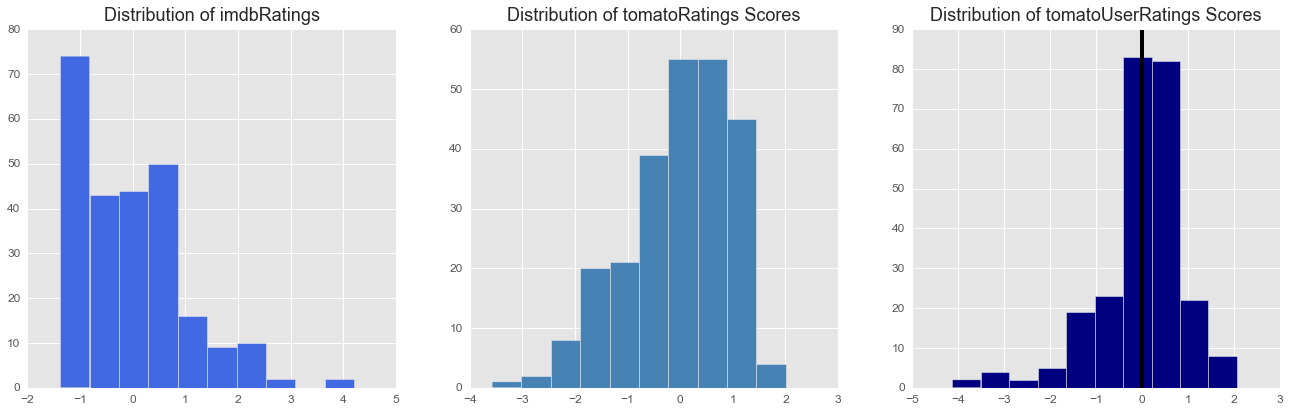

In [518]:
plt.style.use('ggplot')
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,figsize=(20,6))

ax1.hist(df['imdbRating'], color='royalblue')
ax1.set_title('Distribution of imdbRatings', \
             fontsize=18, y=1.01)
ax1.tick_params(labelsize=12)

ax2.hist(df['tomatoRating'], color='steelblue')
ax2.set_title('Distribution of tomatoRatings Scores', \
             fontsize=18, y=1.01)
ax2.tick_params(labelsize=12)

ax3.hist(df['tomatoUserRating'], color='navy')
ax3.set_title('Distribution of tomatoUserRatings Scores', \
             fontsize=18, y=1.01)
ax3.tick_params(labelsize=12)
ax3.vlines(x=0, ymin=0, ymax=90, data=df['tomatoUserRating'])

In [ ]:
tomatoMeter

In [507]:
df['tomatoRating'].value_counts()

 0.145321    24
 1.003518    20
 0.860485    19
-0.426810    14
 0.431387    13
 1.146551    12
 0.002289    12
 0.574420    12
 0.717452    11
-0.712875    10
-0.140744    10
 0.288354     9
-1.571072     9
-0.283777     8
 1.289583     7
-0.569843     7
-1.428039     6
 1.432616     6
-0.998941     6
-1.285006     5
-0.855908     5
-1.141974     5
-2.143203     4
-1.714105     3
-1.857137     2
 1.575649     2
-2.286236     2
-2.572301     1
-2.715334     1
-2.000170     1
-3.573531     1
 2.004747     1
 1.718682     1
-2.429269     1
Name: tomatoRating, dtype: int64

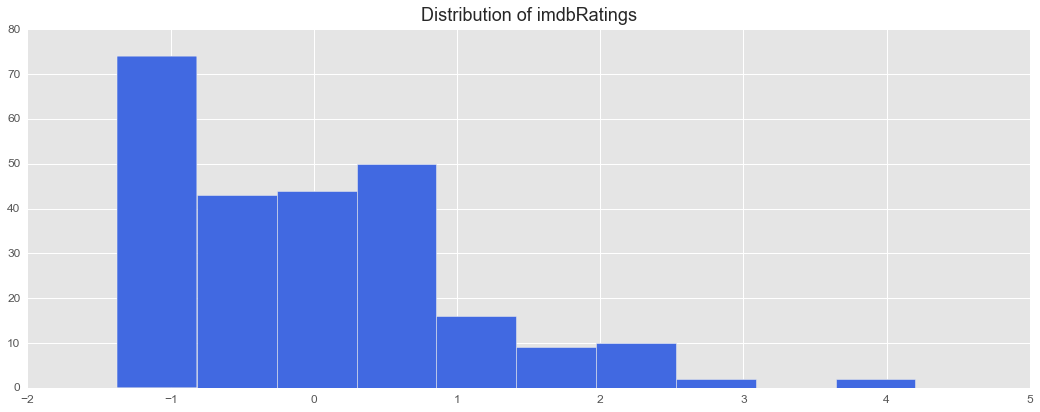

In [213]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(16,6))

imdbRating = df[df['imdbRating'] > 0]
ax.hist(df['imdbRating'], color='royalblue')
ax.set_title('Distribution of imdbRatings', \
             fontsize=18, y=1.01)
ax.tick_params(labelsize=12)

In [259]:
# Create three classification bins
excellent = df['imdbRating'].quantile(0.33)
good = df['imdbRating'].quantile(0.67)   
average = df['imdbRating'].quantile(1.0)   

def class_bins(x):
    if x <= excellent:
        return 'excellent'
    elif x <= good:
        return 'good'
    else:
        return 'average'
    
model_df1['rating'] = df['imdbRating'].apply(class_bins)
model_df1['rating'].head(3)

0    average
1    average
2    average
Name: rating, dtype: object

In [260]:
model_df1['rating'].value_counts()

excellent    117
good          68
average       65
Name: rating, dtype: int64

### Classifiers

In [403]:
# Set X and y
X = model_df1.drop(['imdbRating', 'Released', 'imdbVotes', 'rating'], axis=1)
y = model_df1['rating']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    #random_state=7)

In [347]:
# classifier_list = [
#     ['DecisionTreeClassifier', DecisionTreeClassifier()],
#     ['RandomForestClassifier', RandomForestClassifier()],
#     ['AdaBoostClassifier', AdaBoostClassifier()],
#     ['GradientBoostingClassifier', GradientBoostingClassifier()]]

dtc = DecisionTreeClassifier(random_state=7)
rfc = RandomForestClassifier(random_state=7, n_jobs=-1)
adac = AdaBoostClassifier(random_state=7)
gradc = GradientBoostingClassifier(random_state=7)

classifier_dict = {dtc: 'DecisionTreeClassifier',
                   rfc: 'RandomForestClassifier',
                   adac: 'AdaBoostClassifier',
                   gradc: 'GradientBoostingClassifier'}

In [352]:
classifier_metrics = []

In [349]:
# Return cross_val_score from model
# Cannot add for loop in function as classifiers are not iterable
def run_classifier(classifier):
    score = cross_val_score(classifier, X, y, cv=cv, scoring='accuracy')
    mean = score.mean()
    std = score.std()
    classifier_metrics.append([classifier_dict[classifier], mean, std])
    return classifier_metrics

In [353]:
for i in classifier_dict:
    run_classifier(i)

classifier_metrics

[['RandomForestClassifier', 0.58399999999999996, 0.098305645819556059],
 ['GradientBoostingClassifier', 0.61599999999999999, 0.066211781428987371],
 ['DecisionTreeClassifier', 0.57200000000000006, 0.051536394906900498],
 ['AdaBoostClassifier', 0.53600000000000003, 0.078383671769061705]]

### GridSearch Classifiers

In [420]:
GS_classifier_metrics = []

#### DecisionTree Classifier GS

In [421]:
# DecisionTree GridSearch
parameters = {'max_depth':[5,6], 'max_features':[2,3,4], 
              'max_leaf_nodes':[7,8], 'min_samples_leaf':[2,3,4],
              'min_samples_split':[1]}

classifier = DecisionTreeClassifier(random_state=7)
GS_classifier = GridSearchCV(classifier, parameters, verbose=True, n_jobs=-1)
GS_classifier.fit(X,y)

score = cross_val_score(GS_classifier.best_estimator_, X, y, scoring='accuracy')
mean = score.mean()
std = score.std()
GS_classifier_metrics.append(['DecisionTreeClassifier_GS', mean, std])

print GS_classifier.best_params_
GS_classifier_metrics

Fitting 3 folds for each of 36 candidates, totalling 108 fits
{'max_features': 3, 'max_leaf_nodes': 7, 'min_samples_split': 1, 'max_depth': 5, 'min_samples_leaf': 2}


[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    0.5s finished


[['DecisionTreeClassifier_GS', 0.4800619434765776, 0.0054750815422884127]]

#### RandomForest Classifier GS

In [422]:
# RandomForest GridSearch
parameters = {'max_depth':[4,5,6], 'max_features':[4,5,6], 
              'max_leaf_nodes':[8,10,12], 'min_samples_leaf':[1,2],
              'min_samples_split':[1]}

classifier = RandomForestClassifier(random_state=7)
GS_classifier = GridSearchCV(classifier, parameters, verbose=True, n_jobs=-1)
GS_classifier.fit(X,y)

score = cross_val_score(GS_classifier.best_estimator_, X, y, scoring='accuracy')
mean = score.mean()
std = score.std()
GS_classifier_metrics.append(['RandomForestClassifier_GS', mean, std])

print GS_classifier.best_params_
GS_classifier_metrics

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    5.5s finished


{'max_features': 5, 'max_leaf_nodes': 8, 'min_samples_split': 1, 'max_depth': 4, 'min_samples_leaf': 1}


[['DecisionTreeClassifier_GS', 0.4800619434765776, 0.0054750815422884127],
 ['RandomForestClassifier_GS', 0.53997289972899731, 0.024418265217853008]]

#### GradientBoost Classifier GS

In [423]:
# GradientBoost Classifier GridSearch
parameters = {'max_depth':[3,4], 'max_features':[150,175], 
              'max_leaf_nodes':[15,18], 'min_samples_leaf':[1,2],
              'min_samples_split':[3,5]}

classifier = GradientBoostingClassifier(random_state=7)
GS_classifier = GridSearchCV(classifier, parameters, verbose=True, n_jobs=-1)
GS_classifier.fit(X,y)

score = cross_val_score(GS_classifier.best_estimator_, X, y, scoring='accuracy')
mean = score.mean()
std = score.std()
GS_classifier_metrics.append(['GradientBoostClassifier_GS', mean, std])

print GS_classifier.best_params_
GS_classifier_metrics

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   24.0s finished


{'max_features': 150, 'max_leaf_nodes': 15, 'min_samples_split': 5, 'max_depth': 3, 'min_samples_leaf': 1}


[['DecisionTreeClassifier_GS', 0.4800619434765776, 0.0054750815422884127],
 ['RandomForestClassifier_GS', 0.53997289972899731, 0.024418265217853008],
 ['GradientBoostClassifier_GS', 0.64005032907471937, 0.0065886072106533357]]

### Bagging + GridSearch Classifier

In [427]:
bag_GS_metrics = []

In [428]:
# Bagged GS DecisionTree
classifier = BaggingClassifier(DecisionTreeClassifier())
classifier.fit(X,y)
parameters = {"base_estimator__max_depth": [1,5],
          "base_estimator__max_features": [1,2],
          "base_estimator__min_samples_leaf": [1,3],
          "base_estimator__min_samples_split": [2, 7],
          'max_features': [0.5, 0.7, 1.0],
          'max_samples': [0.5, 0.7, 1.0],
          'n_estimators': [2, 5, 10],
         }

big_classifier = GridSearchCV(classifier, param_grid=parameters, verbose=True)
big_classifier.fit(X,y)

score = cross_val_score(GS_classifier.best_estimator_, X, y, scoring='accuracy')
mean = score.mean()
std = score.std()
bag_GS_metrics.append(['DTClassifier_GS_BAGGED', mean, std])
bag_GS_metrics

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=1)]: Done 1296 out of 1296 | elapsed:  1.0min finished


[['DecisionTreeClassifier_GS_BAGGED',
  0.64005032907471937,
  0.0065886072106533357]]

In [431]:
# Bagged GS RandomForest
classifier = BaggingClassifier(RandomForestClassifier())
classifier.fit(X,y)
parameters = {"base_estimator__max_depth": [1,5],
          "base_estimator__max_features": [1,2],
          "base_estimator__min_samples_leaf": [1,3],
          "base_estimator__min_samples_split": [2, 7],
          'max_features': [0.5,1.0],
          'max_samples': [0.5,1.0],
          'n_estimators': [2,10],
         }

big_classifier = GridSearchCV(classifier, param_grid=parameters, verbose=True)
big_classifier.fit(X,y)

score = cross_val_score(GS_classifier.best_estimator_, X, y, scoring='accuracy', 
                       n_jobs=-1)
mean = score.mean()
std = score.std()
bag_GS_metrics.append(['RFClassifier_GS_BAGGED', mean, std])
bag_GS_metrics

Fitting 3 folds for each of 128 candidates, totalling 384 fits


KeyboardInterrupt: 

### Classifier DataFrame

In [434]:
classification_metrics = []
classification_metrics.extend(classifier_metrics)
classification_metrics.extend(GS_metrics)
classification_metrics.extend(bag_GS_metrics)

In [435]:
classification_metrics

[['RandomForestClassifier', 0.58399999999999996, 0.098305645819556059],
 ['GradientBoostingClassifier', 0.61599999999999999, 0.066211781428987371],
 ['DecisionTreeClassifier', 0.57200000000000006, 0.051536394906900498],
 ['AdaBoostClassifier', 0.53600000000000003, 0.078383671769061705],
 ['DecisionTree_GS', 0.78149650038472429, 0.20661954660954565],
 ['RandomForest_GS', 0.61929128240020648, 0.092159867261356596],
 ['GradientBoost_GS', 0.29560906664681702, 0.038834226668743567],
 ['DecisionTreeClassifier_GS_BAGGED',
  0.64005032907471937,
  0.0065886072106533357]]

In [442]:
class_df = pd.DataFrame(classification_metrics, 
                        columns=['Model_Name', 'Mean_Accuracy', 'Accuracy_Std'])
class_df.sort_values('Mean_Accuracy', ascending=False)

,Model_Name,Mean_Accuracy,Accuracy_Std
4,DecisionTree_GS,0.781497,0.206620
7,DecisionTreeClassifier_GS_BAGGED,0.640050,0.006589
5,RandomForest_GS,0.619291,0.092160
1,GradientBoostingClassifier,0.616000,0.066212
0,RandomForestClassifier,0.584000,0.098306
2,DecisionTreeClassifier,0.572000,0.051536
3,AdaBoostClassifier,0.536000,0.078384
6,GradientBoost_GS,0.295609,0.038834


In [441]:
reg_df.sort_values('MSE_Mean', ascending=False)

,Model_Name,MSE_Mean,MSE_Std
11,DecisionTree_GS,0.781497,0.206620
12,RandomForest_GS,0.619291,0.092160
0,DecisionTree_Reg,0.540264,0.064395
8,ExtraTrees_Reg_BAGGING,0.361375,0.047003
4,AdaBoost_Reg,0.350632,0.065206
3,ExtraTrees_Reg,0.349265,0.043135
9,AdaBoost_Reg_BAGGING,0.347076,0.049844
1,Bagging_Reg,0.338018,0.077113
6,DecisionTree_Reg_BAGGING,0.338018,0.077113
2,RandomForest_Reg,0.332196,0.080784


In [445]:
reg_df.columns = ['Model_Name', 'Mean_Score', 'Score_Std']
class_df.columns = ['Model_Name', 'Mean_Score', 'Score_Std']

In [458]:
reg_median = reg_df['Mean_Score'].median()
class_median = class_df['Mean_Score'].median()
print reg_median
print class_median

0.342547072765
0.6


In [457]:
metrics_df = pd.concat([reg_df, class_df])
metrics_df.reset_index(drop=True, inplace=True)
metrics_df.drop_duplicates(inplace=True)
metrics_df.sort_values('Mean_Score', ascending=False)

,Model_Name,Mean_Score,Score_Std
11,DecisionTree_GS,0.781497,0.206620
21,DecisionTreeClassifier_GS_BAGGED,0.640050,0.006589
12,RandomForest_GS,0.619291,0.092160
15,GradientBoostingClassifier,0.616000,0.066212
14,RandomForestClassifier,0.584000,0.098306
16,DecisionTreeClassifier,0.572000,0.051536
0,DecisionTree_Reg,0.540264,0.064395
17,AdaBoostClassifier,0.536000,0.078384
8,ExtraTrees_Reg_BAGGING,0.361375,0.047003
4,AdaBoost_Reg,0.350632,0.065206


In [ ]:
GradientBoostingClassifier

In [519]:
metrics_df

,Model_Name,Mean_Score,Score_Std
0,DecisionTree_Reg,0.540264,0.064395
1,Bagging_Reg,0.338018,0.077113
2,RandomForest_Reg,0.332196,0.080784
3,ExtraTrees_Reg,0.349265,0.043135
4,AdaBoost_Reg,0.350632,0.065206
5,GradientBoost_Reg,0.270723,0.057938
6,DecisionTree_Reg_BAGGING,0.338018,0.077113
7,RandomForest_Reg_BAGGING,0.328135,0.062388
8,ExtraTrees_Reg_BAGGING,0.361375,0.047003
9,AdaBoost_Reg_BAGGING,0.347076,0.049844


In [486]:
sub.shape

(19, 2)

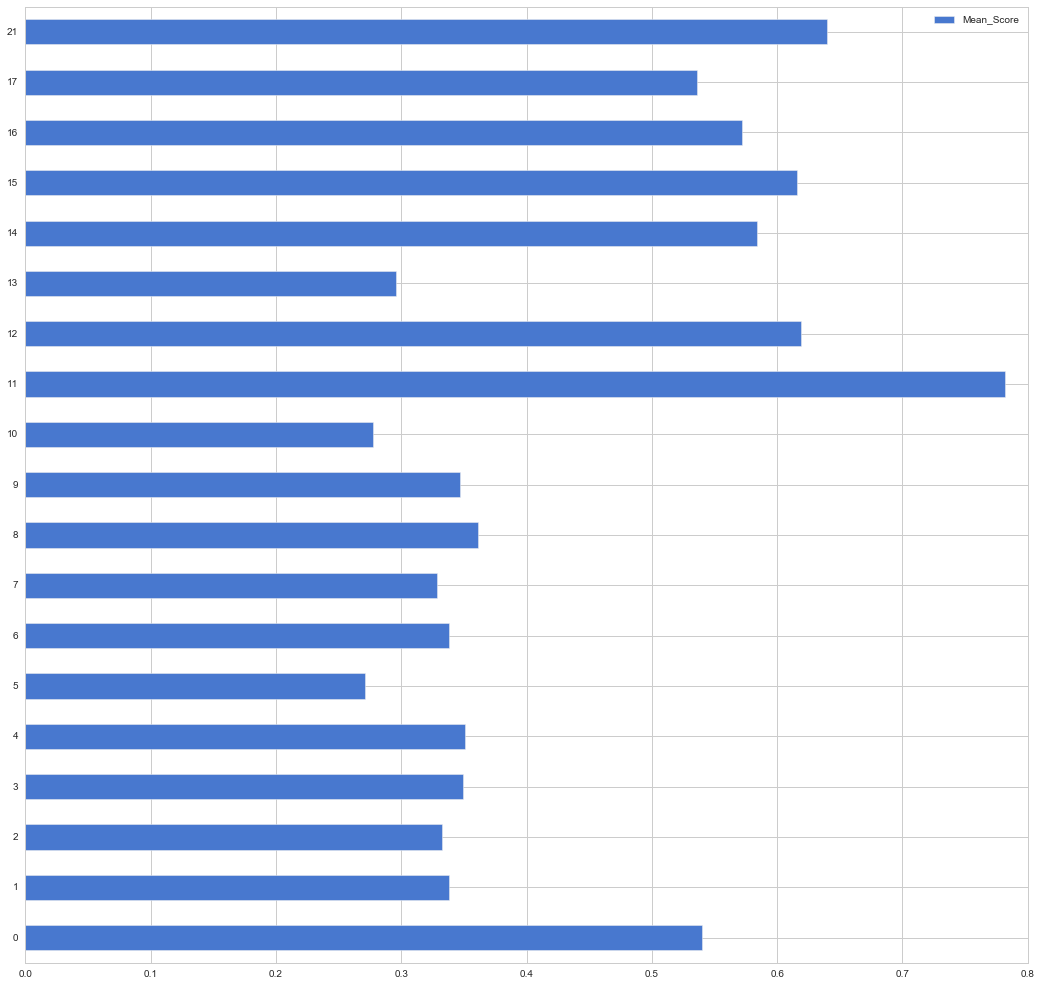

In [490]:
sub_cols = ['Model_Name', 'Mean_Score']
sub = metrics_df.iloc[:, :-1]
ax = sub.plot(kind='barh', figsize=(16,16))


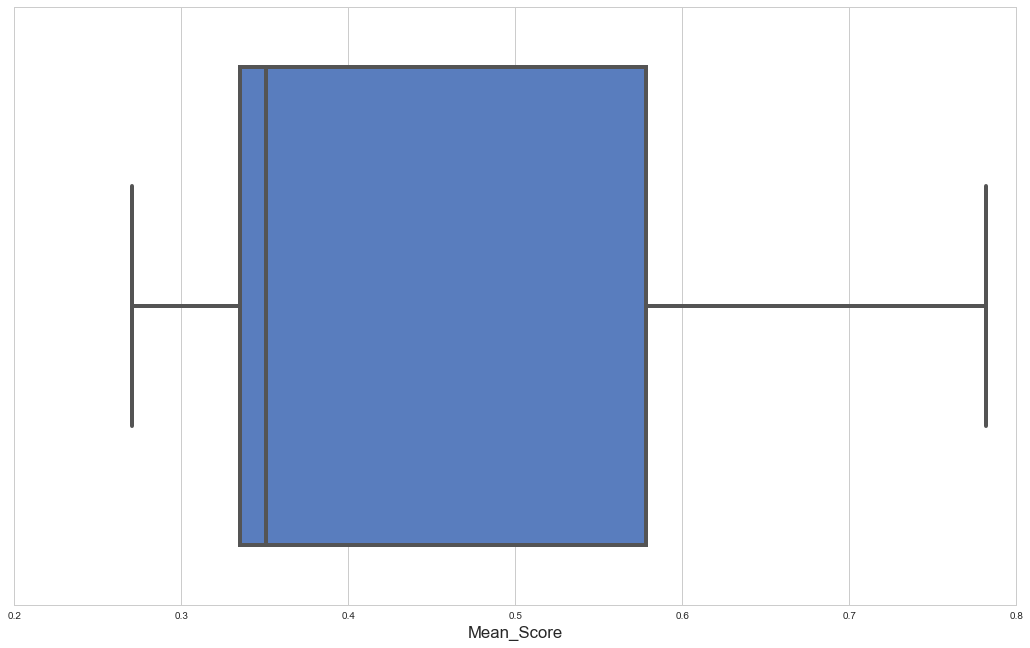

In [464]:
fig, ax = plt.subplots(figsize=(16,10))
sns.boxplot(x=metrics_df['Model_Name'], y=metrics_df['Mean_Score'])